In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from functools import reduce
import seaborn as sns

%run Thesis_Model_Function.ipynb

Run Complete: 15/07/2024 14:22:30


Run Complete: 15/07/2024 14:22:31


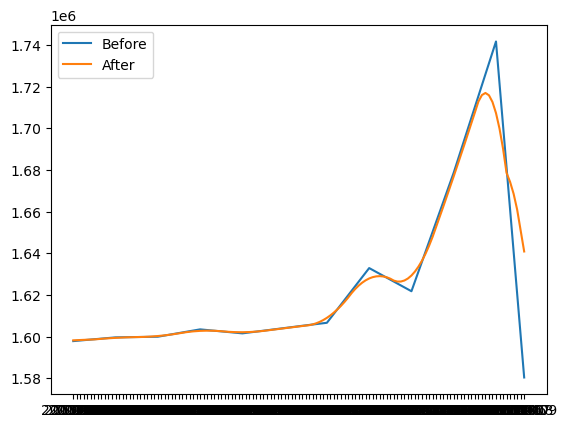

Run Complete: 15/07/2024 14:22:34


In [92]:
%run Thesis_SWE_Data_Prep.ipynb

## VARMAX Model Selection 

In [6]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - best model 2 common, 3 regional, 2 AR, 4 MA
#  - With Exogenous variables pre-COVID period - best model 2 common, 2 regional , 3 AR, 6 MA
#  - No Exogenous variables COVID period - best model 3 common 3 regional, 3 AR, 2 MA
#  - With Exogenous variables COVID period - best model 1 common, 2 regional,2 AR, 4 MA
import numpy as np
import random

train_size =  60 #84
regional_logmort_train = malmo_logmort_full.iloc[:, :train_size]
country_logmort_train = all_swe_logmort.iloc[:, :train_size]
num_iters = 75
common_limit = 3
regional_limit = 3
ar_limit = 5
ma_limit = 5

track_params = np.full((common_limit+1, regional_limit+1, ar_limit+1, ma_limit+1), 0)
error_store = np.full((common_limit+1, regional_limit+1, ar_limit+1, ma_limit+1), np.inf)

for i in range(num_iters):
    # Initialize random parameters
    common_terms = random.randint(1, common_limit)
    regional_terms = random.randint(1, regional_limit)
    ar = random.randint(1, ar_limit)
    ma = random.randint(1, ma_limit)
    
    # Generate new parameters if already used
    while track_params[common_terms, regional_terms, ar, ma] == 1:
        common_terms = random.randint(1, common_limit)
        regional_terms = random.randint(1, regional_limit)
        ar = random.randint(1, ar_limit)
        ma = random.randint(1, ma_limit)
    
    try:
        # Train the model
        track_params[common_terms, regional_terms, ar, ma] = 1
        _, _, _, _, _, _, _, _, _, _, model, _, test_errors,_,_ = VARMAX_model(
            country_logmort_train, regional_logmort_train, 
            common_terms=common_terms, regional_terms=regional_terms, 
            prediction_period=20, train_period=40, AR=ar+1, MA=ma+1,
            
#             exogenous_train=exog_train_malmo, exogenous_test=exog_test_malmo,
#             country_deaths=swe_death, country_pop=swe_pop, 
#             region_deaths=malmo_death, region_pop=malmo_pop,
            
#             exogenous_train=exog_train_malmo_select, exogenous_test=exog_test_malmo_select,
             country_deaths=swe_death_select, country_pop=swe_pop_select, 
             region_deaths=malmo_death_select, region_pop=malmo_pop_select,
            re_est=False,smooth = False)
        print(test_errors)
        # Store the mean of test_errors in the appropriate location
        error_store[common_terms, regional_terms, ar, ma] = np.mean(test_errors) 
    except Exception as e:
        print(f"Error in configuration: AR={ar+1}, MA={ma+1}, Common Terms={common_terms}, Regional Terms={regional_terms}. Error: {str(e)}")
        error_store[common_terms, regional_terms, ar, ma] = np.inf  # Set a large error value
                
    print(f"Configuration {i+1} processed: AR={ar+1}, MA={ma+1}, Common Terms={common_terms}, Regional Terms={regional_terms}, Error={error_store[common_terms, regional_terms, ar, ma]}")

    
    
    
print(np.where(error_store == np.min(error_store)))

[4.51790546 2.44818528 1.13991425 2.23308949 2.16365262]
Configuration 1 processed: AR=6, MA=6, Common Terms=2, Regional Terms=2, Error=2.5005494188611004
[4.15913433 1.92714583 1.16301355 1.99478277 2.33220283]
Configuration 2 processed: AR=5, MA=2, Common Terms=1, Regional Terms=3, Error=2.3152558623181068
Error in configuration: AR=6, MA=2, Common Terms=3, Regional Terms=3. Error: Matrix is not positive definite
Configuration 3 processed: AR=6, MA=2, Common Terms=3, Regional Terms=3, Error=inf
[4.28984331 2.02079812 1.23260896 2.24228323 2.4076342 ]
Configuration 4 processed: AR=4, MA=5, Common Terms=3, Regional Terms=1, Error=2.4386335634593346
[4.45255474 1.9940316  1.34736786 2.16590698 2.17762495]
Configuration 5 processed: AR=3, MA=3, Common Terms=3, Regional Terms=2, Error=2.4274972282441447
[4.25371605 1.81410664 1.43781472 2.18421985 2.34648464]
Configuration 6 processed: AR=2, MA=3, Common Terms=1, Regional Terms=2, Error=2.40726837845709
[4.75678574 2.20340988 1.31565002 2

In [7]:
np.min(error_store)

2.2799019778918583

In [40]:
np.min(error_store)

1.3332326645333408

In [30]:
_, _, _, _, _, _, _, _, _, _, model, _, test_errors = VARMAX_model(
                        country_logmort_train, regional_logmort_train, 
                        common_terms=3, regional_terms=3, 
                        prediction_period=20, train_period=40, AR=2, MA=6,
                        #exogenous_train = exog_train_malmo_select,exogenous_test = exog_test_malmo_select,
                        country_deaths = swe_death_select,country_pop=swe_pop_select, region_deaths=malmo_death_select,
                        region_pop=malmo_pop_select, re_est=True)

print(np.mean(test_errors))

1.5196521668187253


## SARIMAX Model Selection

In [123]:
print(f"Lowest Error Configuration: Index: {index}, AR: {ar + 1}, MA: {ma + 1}, Common Terms: {common_terms}, Regional Terms: {regional_terms}")
print(ar+1,ma+1,common_terms,regional_terms)
np.min(error_store)


Lowest Error Configuration: Index: 8, AR: 1, MA: 2, Common Terms: 3, Regional Terms: 3
1 2 3 3


1.2719502016269817

In [4]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - 4 Common, 1 Regional - no smoothing
#  - With Exogenous variables pre-COVID period - 4 common, 1 regional - no smoothing

# Not neccessary
#  - No Exogenous variables COVID period -  2 common, 1 regional
#  - With Exogenous variables COVID period - 3 common 1 regional

train_size = 60 #84 #06
regional_logmort_train =  malmo_logmort_incCOVID.iloc[:,:train_size] #malmo_logmort_full.iloc[:,:train_size]
country_logmort_train =  all_swe_logmort_incCOVID.iloc[:,:train_size] # all_swe_logmort.iloc[:,:train_size]
exog_train =  exog_train_malmo.iloc[:40,]  #exog_train_malmo_COVID.iloc[:60,] # exog_train_malmo.iloc[:40,]  
exog_test = exog_train_malmo.iloc[40:,] # exog_train_malmo_COVID.iloc[60:,] # exog_train_malmo.iloc[40:,]  

error_store = np.zeros((4,4))

for com in range(1,5):
    for reg in range(1,5):
        _,_,_,_,_,_,_,_,_,_,_,regional_predictions,_,_,model_error,res,_,_ = full_model(country_logmort_train,regional_logmort_train,
                                                                                    common_terms = com,regional_terms = reg,
                                                                                    prediction_period = 20,train_period = 40,
                                                                                    exogenous_train = exog_train,exogenous_test = exog_test,
                                                                                    country_deaths = swe_death_select, country_pop = swe_pop_select,
                                                                                    region_deaths = malmo_death_select,region_pop = malmo_pop_select,
                                                                                    
                                                                                    #exogenous_train = exog_train,exogenous_test = exog_test,
                                                                                    #country_deaths=swe_death, country_pop=swe_pop, 
                                                                                    #region_deaths=malmo_death, region_pop=malmo_pop,
                                                                                    re_est = False,smooth = False) 
        print(model_error)
        
        regional_predictions = pd.DataFrame(regional_predictions)
        regional_predictions.index = regional_logmort_train.index
        regional_predictions.columns = regional_logmort_train.columns
        
        errors = MAPE(regional_predictions.iloc[:,40:],regional_logmort_train.iloc[:,40:]) #60
        error_store[com-1,reg-1] = np.mean(errors)
        
        
        
print(error_store)

p_value k_t0 before re-estimation: 0.9289333741383635 

Regional k_t0 is white noise with LB p_value 0.9289333741383635 

p_value k_t0 after re-estimation: 0.9289333741383635 

Regional k_t0 is white noise with LB p_value 0.9289333741383635 

5.4041700570988676
p_value k_t0 before re-estimation: 0.9289333741383635 

Regional k_t0 is white noise with LB p_value 0.9289333741383635 

p_value k_t1 before re-estimation: 0.13248299493314272 

Regional k_t1 is white noise with LB p_value 0.13248299493314272 

p_value k_t0 after re-estimation: 0.9289333741383635 

Regional k_t0 is white noise with LB p_value 0.9289333741383635 

p_value k_t1 after re-estimation: 0.13248299493314272 

Regional k_t1 is white noise with LB p_value 0.13248299493314272 

5.625644145374605
p_value k_t0 before re-estimation: 0.9289333741383635 

Regional k_t0 is white noise with LB p_value 0.9289333741383635 

p_value k_t1 before re-estimation: 0.13248299493314272 

Regional k_t1 is white noise with LB p_value 0.1324

## SARIMAX Models

# Testing model with no common parameters

In [12]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - 2 regional terms
#  - With Exogenous variables pre-COVID period - 3 Regional terms 
#  - No Exogenous variables COVID period - 2 Regional terms
#  - With Exogenous variables COVID period - 2 Regional terms

train_size =   84 # 60
regional_logmort_train = malmo_logmort_incCOVID.iloc[:,:train_size] #malmo_logmort_full.iloc[:,:train_size]
country_logmort_train = all_swe_logmort_incCOVID.iloc[:,:train_size] #all_swe_logmort.iloc[:,:train_size]
exog_train = exog_train_malmo_COVID.iloc[:60,] #exog_train_malmo.iloc[:40,]
exog_test = exog_train_malmo_COVID.iloc[60:,] #exog_train_malmo.iloc[40:,]

error_store = np.zeros((2,5))

for com in range(1,3):
    for reg in range(1,6):
        
        if com == 1:
            smth = True
        else:
            smth = False
        _,_,_,_,_,_,regional_predictions,_,_,model_error,res,_ = model_no_common(regional_logmort_train,
                                                                               regional_terms = reg,
                                                                               prediction_period = 24,train_period = 60,
                                                                               region_deaths = malmo_death,region_pop = malmo_pop,
                                                                               exogenous_train = exog_train,exogenous_test = exog_test,
                                                                               re_est = False,smooth = smth)
 
        
        regional_predictions = pd.DataFrame(regional_predictions)
        regional_predictions.index = regional_logmort_train.index
        regional_predictions.columns = regional_logmort_train.columns
        
        errors = MAPE(regional_predictions.iloc[:,60:],regional_logmort_train.iloc[:,60:])
        error_store[com-1,reg-1] = np.mean(errors)
        
        
        
print(error_store)

p_value k_t0 before re-estimation: 1.5615492731922903e-09 

p_value k_t0 after re-estimation: 1.5615492731922903e-09 

p_value k_t0 before re-estimation: 1.5615492731922903e-09 

p_value k_t1 before re-estimation: 1.080612947369897e-83 

p_value k_t0 after re-estimation: 1.5615492731922903e-09 

p_value k_t1 after re-estimation: 1.080612947369897e-83 

p_value k_t0 before re-estimation: 1.5615492731922903e-09 

p_value k_t1 before re-estimation: 1.080612947369897e-83 

p_value k_t2 before re-estimation: 4.278046291599091e-38 

p_value k_t0 after re-estimation: 1.5615492731922903e-09 

p_value k_t1 after re-estimation: 1.080612947369897e-83 

p_value k_t2 after re-estimation: 4.278046291599091e-38 

p_value k_t0 before re-estimation: 1.5615492731922903e-09 

p_value k_t1 before re-estimation: 1.080612947369897e-83 

p_value k_t2 before re-estimation: 4.278046291599091e-38 

p_value k_t3 before re-estimation: 3.254202212330307e-05 

p_value k_t0 after re-estimation: 1.5615492731922903e-0

p_value k_t0 before re-estimation: 0.27002033746178256 

Regional k_t0 is white noise with LB p_value 0.27002033746178256 

p_value k_t1 before re-estimation: 1.3183308764510714e-16 

Proportion of k_t values which are positive[0.53333333 0.53333333] 

Proportion of b_x values which are positive[0.2 0.2] 

p_value k_t0 after re-estimation: 0.7680796009108418 

Regional k_t0 is white noise with LB p_value 0.7680796009108418 

p_value k_t1 after re-estimation: 4.950754360673799e-07 

Model Error 6.329226476269937
Re_estimation error Each Age Group (MAPE): [0.03995206 0.64786861 0.82465171 0.87083706 0.81762539]

 Prediction Error Each Age Group (MAPE)[1.7126003  1.35442753 0.82369609 1.20090986 1.23759269]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                        SARIMAX   Log Likelihood                  37.694
Date:                Mon, 15 Jul 2024   AIC      

<Figure size 640x480 with 0 Axes>

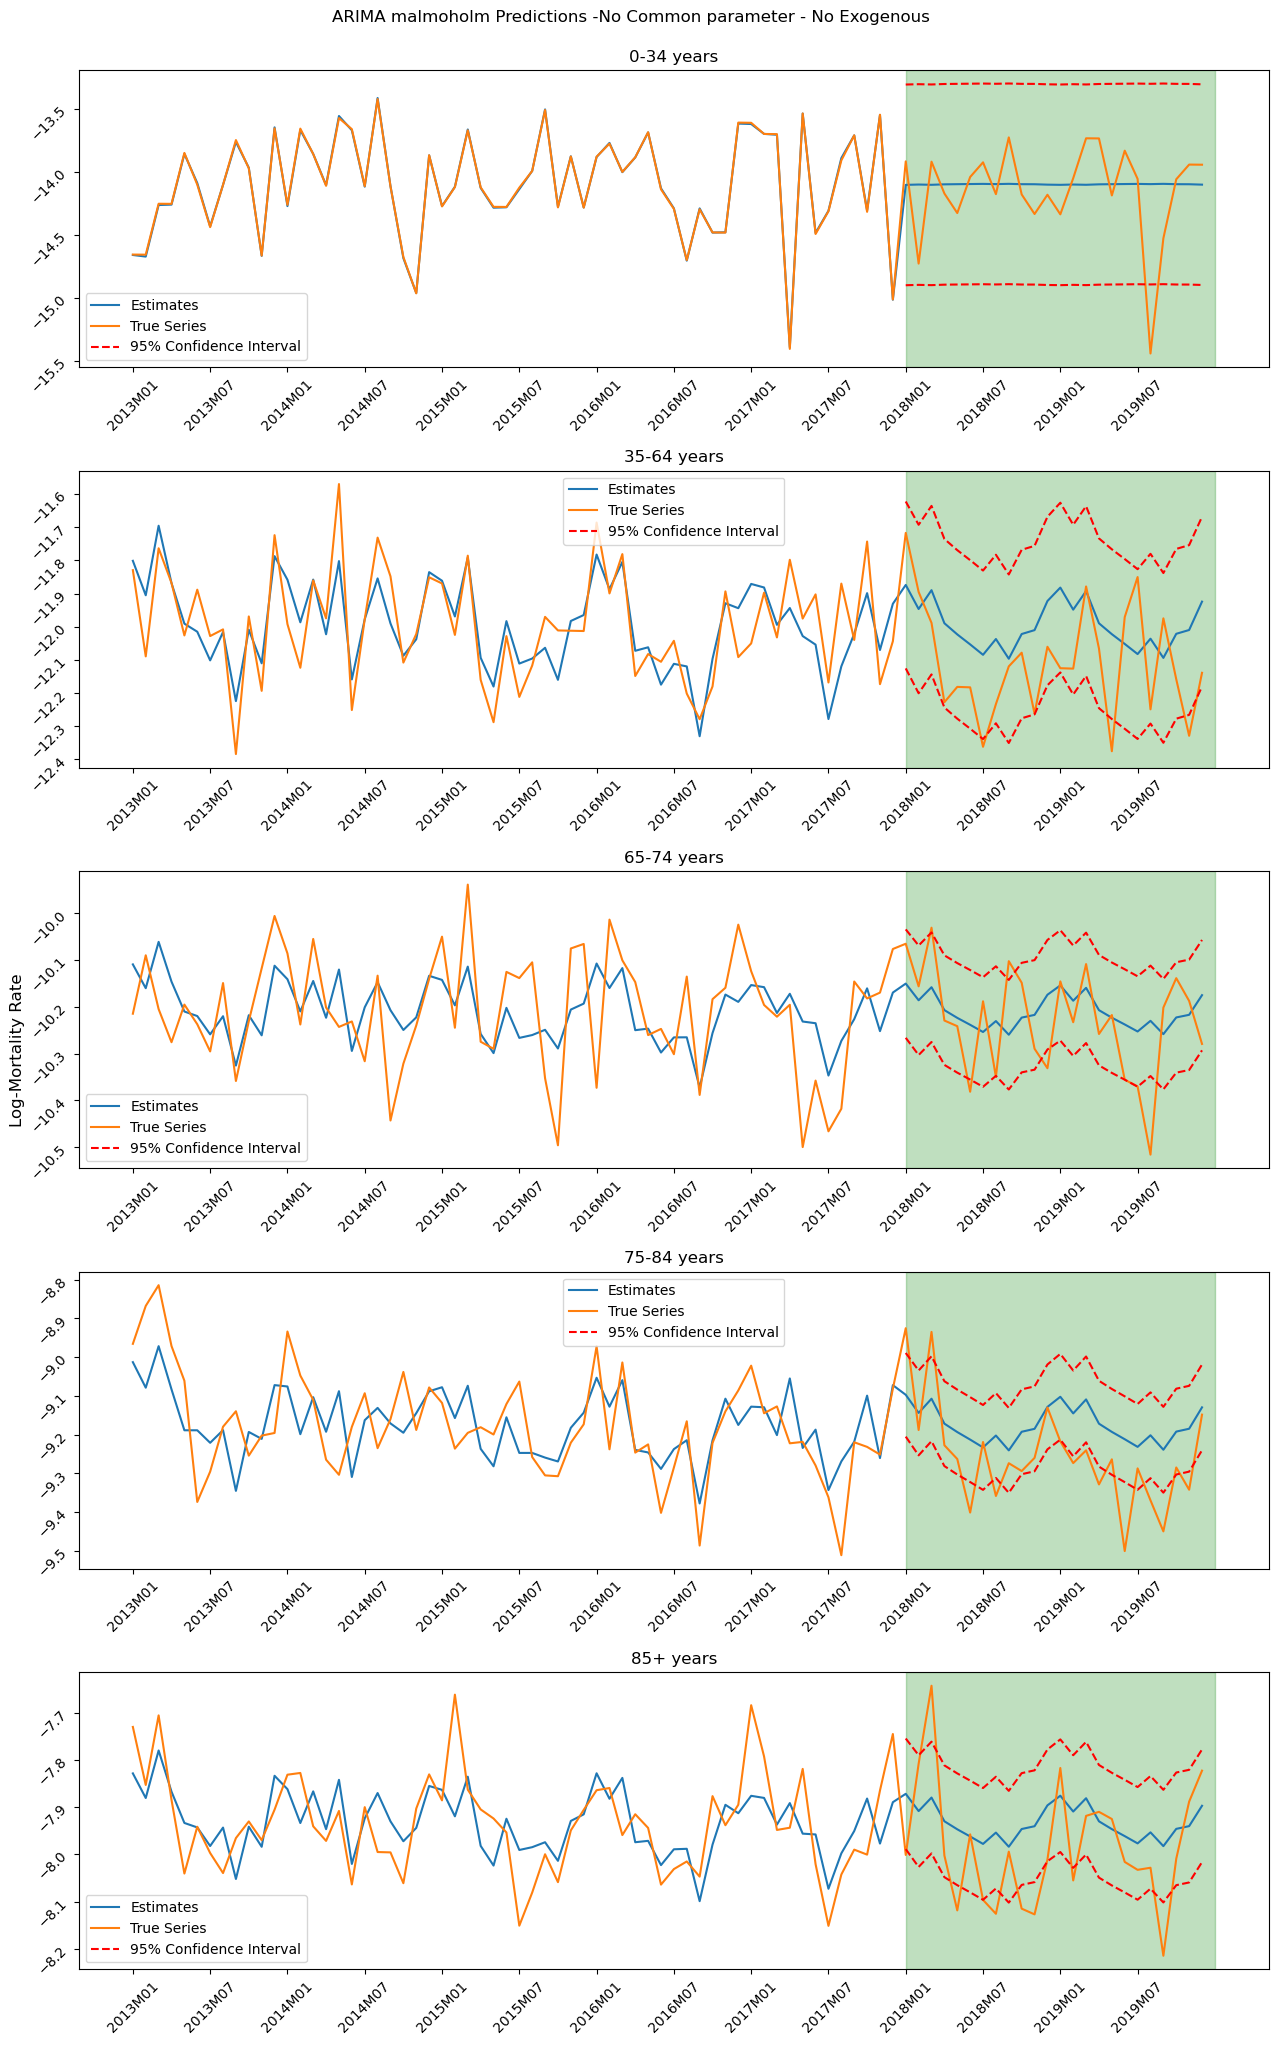

In [94]:
## Model No Common parameter - No Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommout,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_ = model_no_common(malmo_logmort_full,regional_terms = 2,prediction_period = 24,train_period = 60,region_deaths = malmo_death,region_pop = malmo_pop,re_est = False,smooth = False)

#exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo
regional_predictions_nocommout = pd.DataFrame(regional_predictions_nocommout)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommout.index = malmo_logmort_full.index
regional_predictions_nocommout.columns = malmo_logmort_full.columns
regional_predictions_upconf.index = malmo_logmort_full.index
regional_predictions_upconf.columns = malmo_logmort_full.columns
regional_predictions_lowconf.index = malmo_logmort_full.index
regional_predictions_lowconf.columns = malmo_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommout.iloc[:,:60],malmo_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommout.iloc[:,60:],malmo_logmort_full.iloc[:,60:])))
print(k_t_models["model_0"].summary())

error_NoCom_wout = MAPE(regional_predictions_nocommout.iloc[:,60:],malmo_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_nocommout,regional_predictions_upconf,regional_predictions_lowconf,24,malmo_logmort_full,suptitle = "ARIMA malmoholm Predictions -No Common parameter - No Exogenous ")



In [95]:
print(k_t_models["model_0"].summary())
print("\n")
print(k_t_models["model_1"].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                        SARIMAX   Log Likelihood                  37.694
Date:                Mon, 15 Jul 2024   AIC                            -73.388
Time:                        14:23:55   BIC                            -71.294
Sample:                             0   HQIC                           -72.569
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0167      0.003      5.933      0.000       0.011       0.022
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 4.84
Prob(Q):                              0.66   Pr

p_value k_t0 before re-estimation: 0.27002033746178256 

Regional k_t0 is white noise with LB p_value 0.27002033746178256 

p_value k_t1 before re-estimation: 1.3183308764510714e-16 

p_value k_t2 before re-estimation: 0.014106435054356329 

Proportion of k_t values which are positive[0.53333333 0.53333333 0.41666667] 

Proportion of b_x values which are positive[0.2 0.2 0.2] 

p_value k_t0 after re-estimation: 0.7680796009108418 

Regional k_t0 is white noise with LB p_value 0.7680796009108418 

p_value k_t1 after re-estimation: 4.950754360673799e-07 

p_value k_t2 after re-estimation: 0.7778869862735386 

Regional k_t2 is white noise with LB p_value 0.7778869862735386 

Model Error 6.529374096687351
Re_estimation error Each Age Group (MAPE): [0.01982329 0.05711856 0.70136589 0.56798507 0.69965858]

 Prediction Error Each Age Group (MAPE)[1.80752106 1.28947218 0.90946674 1.32202155 1.20089257]
                               SARIMAX Results                                
Dep. Variable

<Figure size 640x480 with 0 Axes>

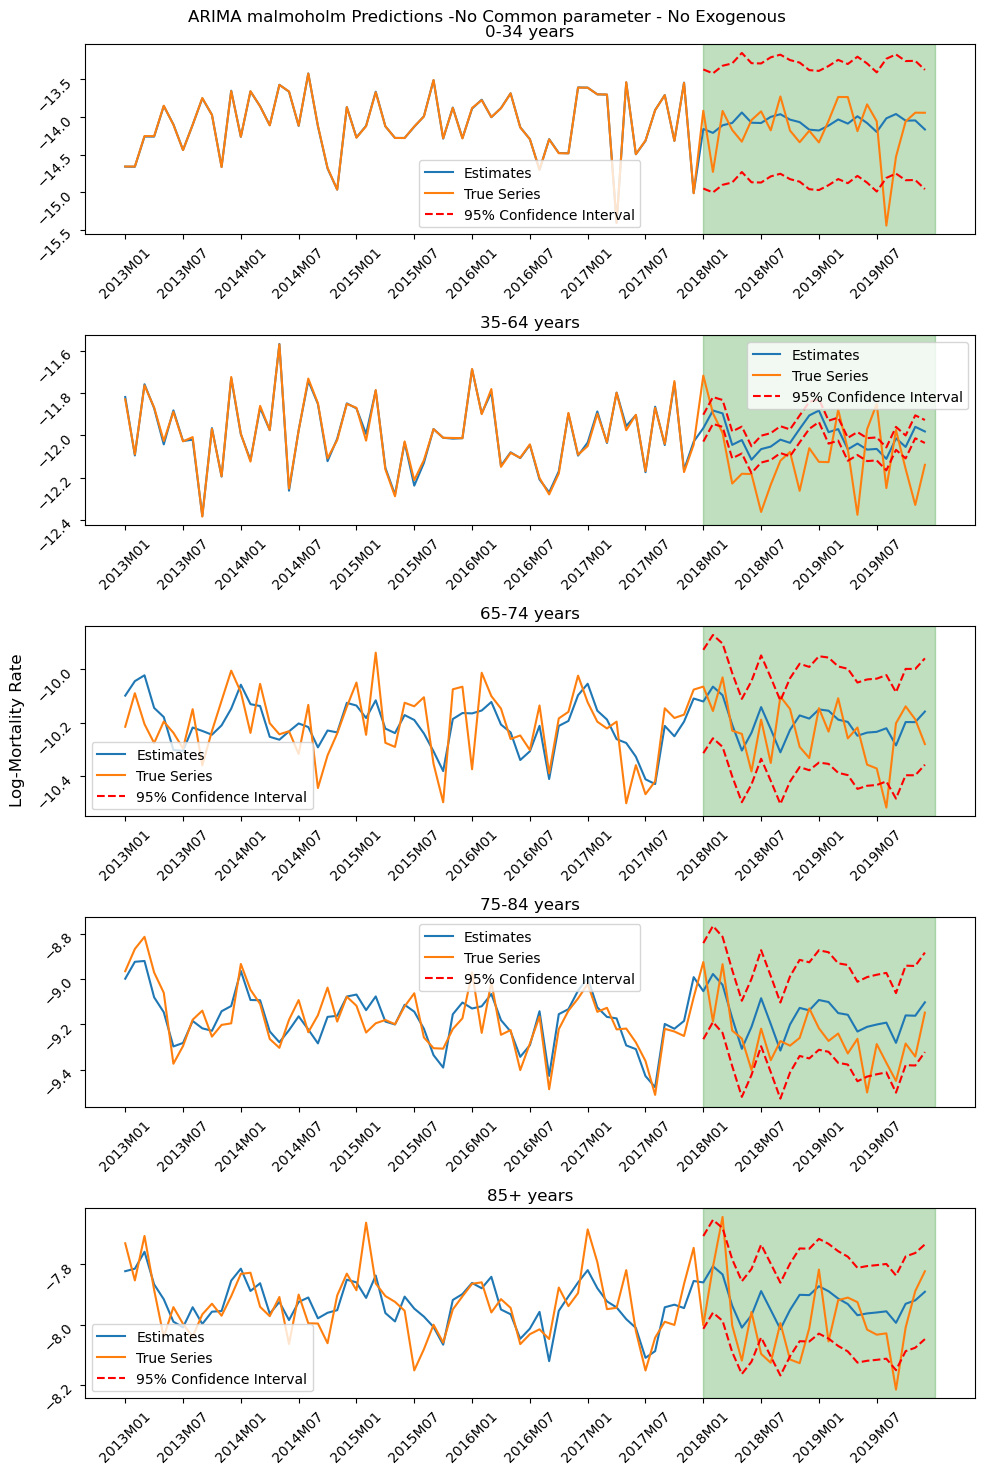

In [71]:
## Model No Common parameter - with Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommwith,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_ = model_no_common(malmo_logmort_full,regional_terms = 3,prediction_period = 24,train_period = 60,exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo,region_deaths = malmo_death,region_pop = malmo_pop,re_est = False,smooth = False)

#exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo
regional_predictions_nocommwith = pd.DataFrame(regional_predictions_nocommwith)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommwith.index = malmo_logmort_full.index
regional_predictions_nocommwith.columns = malmo_logmort_full.columns
regional_predictions_upconf.index = malmo_logmort_full.index
regional_predictions_upconf.columns = malmo_logmort_full.columns
regional_predictions_lowconf.index = malmo_logmort_full.index
regional_predictions_lowconf.columns = malmo_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommwith.iloc[:,:60],malmo_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommwith.iloc[:,60:],malmo_logmort_full.iloc[:,60:])))
print(k_t_models["model_0"].summary())

error_NoCom_with = MAPE(regional_predictions_nocommwith.iloc[:,60:],malmo_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_nocommwith,regional_predictions_upconf,regional_predictions_lowconf,24,malmo_logmort_full,suptitle = "ARIMA malmoholm Predictions -No Common parameter - No Exogenous ")



In [67]:
# print(k_t_models['model_0'].summary())
# print(k_t_models['model_1'].summary())
# print(k_t_models['model_2'].summary())

print(b_xs)
b_xs[b_xs > 0] = 1
b_xs[b_xs < 0] = 0
np.sum(b_xs,axis = 0)/b_xs.shape[0]

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


array([0.2, 0.2, 0.2])

# SARIMAX Models pre-COVID With Common terms

Common k_t3 is white noise with LB p_value 0.8370848936439318
p_value k_t0 before re-estimation: 0.2227094615277249 

Regional k_t0 is white noise with LB p_value 0.2227094615277249 

p_value k_t0 after re-estimation: 0.2227094615277249 

Regional k_t0 is white noise with LB p_value 0.2227094615277249 

Model Error 4.5261858431786175
Re_estimation error Each Age Group (MAPE): [0.03636507 0.98739211 0.91781996 0.87529179 0.67918707]

 Prediction Error Each Age Group (MAPE)[1.74681181 1.14093048 0.80991686 0.93366534 1.1735309 ]


<Figure size 640x480 with 0 Axes>

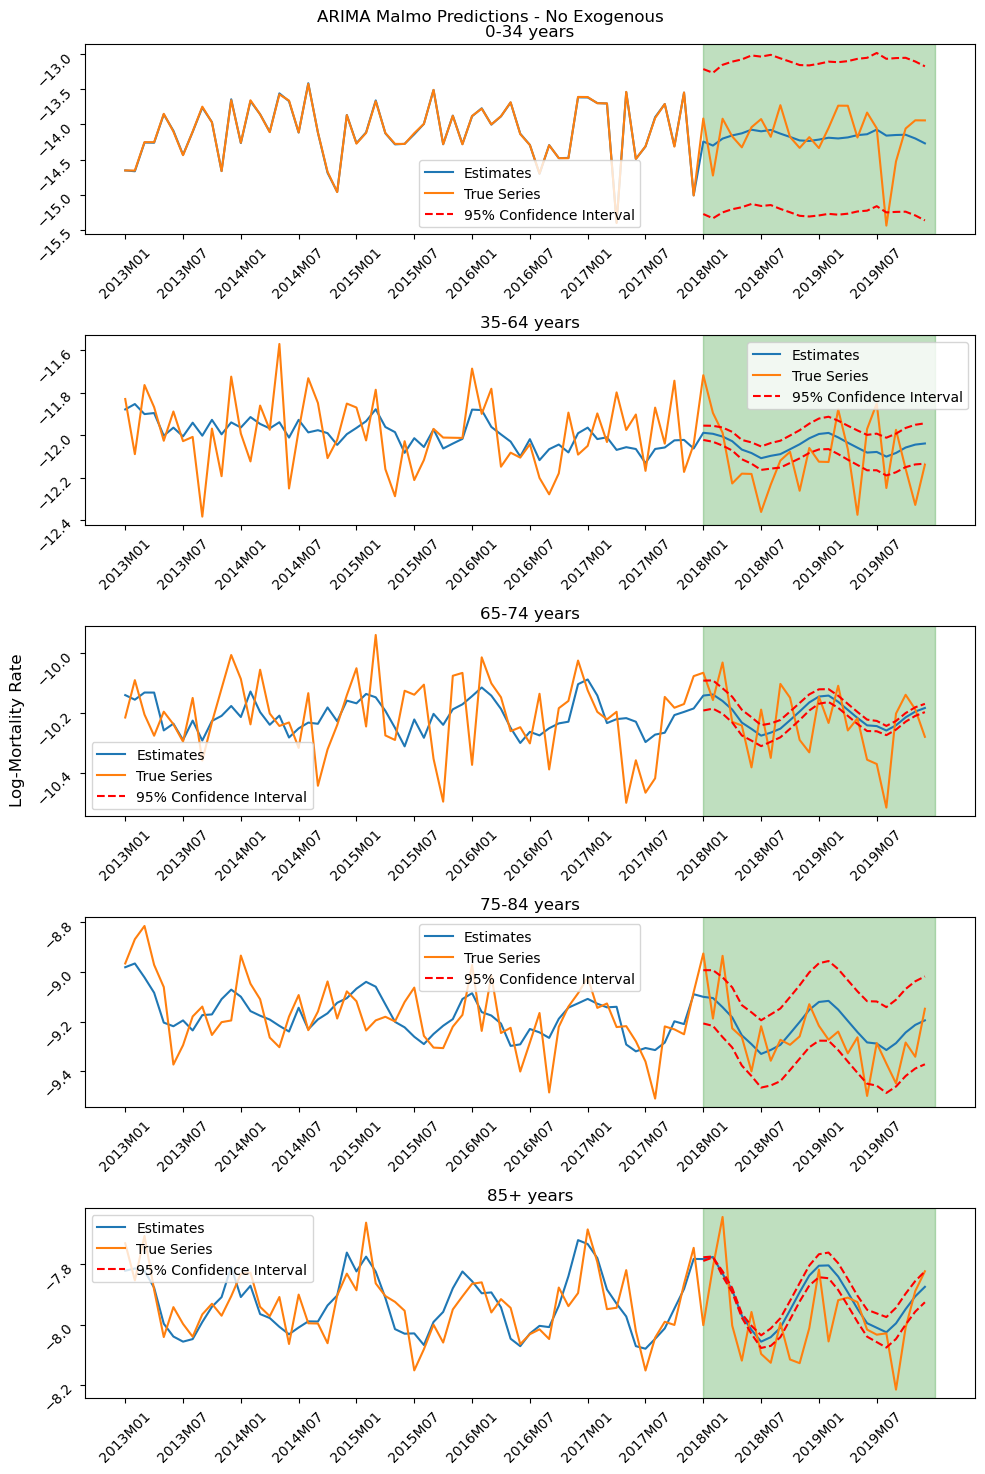

In [72]:
### Without Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models,K_t_preds,k_t_preds,regional_predictions_sarout,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_swe_logmort,malmo_logmort_full, common_terms = 4,regional_terms = 1,prediction_period = 24,train_period = 60,country_deaths = swe_death, country_pop = swe_pop,region_deaths = malmo_death,region_pop = malmo_pop,re_est = False,smooth = False)  


regional_predictions_sarout = pd.DataFrame(regional_predictions_sarout)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarout.index = malmo_logmort_full.index
regional_predictions_sarout.columns = malmo_logmort_full.columns
regional_predictions_upconf.index = malmo_logmort_full.index
regional_predictions_upconf.columns = malmo_logmort_full.columns
regional_predictions_lowconf.index = malmo_logmort_full.index
regional_predictions_lowconf.columns = malmo_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarout.iloc[:,:60],malmo_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarout.iloc[:,60:],malmo_logmort_full.iloc[:,60:])))

error_SARIMAX_wout = MAPE(regional_predictions_sarout.iloc[:,60:],malmo_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_sarout,regional_predictions_upconf,regional_predictions_lowconf,24,malmo_logmort_full,suptitle = "ARIMA Malmo Predictions - No Exogenous")



In [18]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print(str(K_t_models["model_1"].get_params()["order"]) + str(K_t_models["model_1"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models["model_0"].get_params()["order"]) + str(k_t_models["model_0"].get_params()["seasonal_order"]))
print(str(k_t_models["model_1"].get_params()["order"]) + str(k_t_models["model_1"].get_params()["seasonal_order"]))



(1, 0, 0)(2, 0, 1, 12)
(1, 1, 1)(2, 0, 0, 12)
-
(1, 0, 0)(0, 0, 0, 12)
(0, 0, 0)(0, 0, 2, 12)


Common k_t3 is white noise with LB p_value 0.8370848936439318
p_value k_t0 before re-estimation: 0.2227094615277249 

Regional k_t0 is white noise with LB p_value 0.2227094615277249 

p_value k_t0 after re-estimation: 0.2227094615277249 

Regional k_t0 is white noise with LB p_value 0.2227094615277249 

Re_estimation error Each Age Group (MAPE): [0.03636507 0.98739211 0.91781996 0.87529179 0.67918707]

 Prediction Error Each Age Group (MAPE)[1.82741335 1.14715235 0.80622444 0.92246002 1.17320474]


<Figure size 640x480 with 0 Axes>

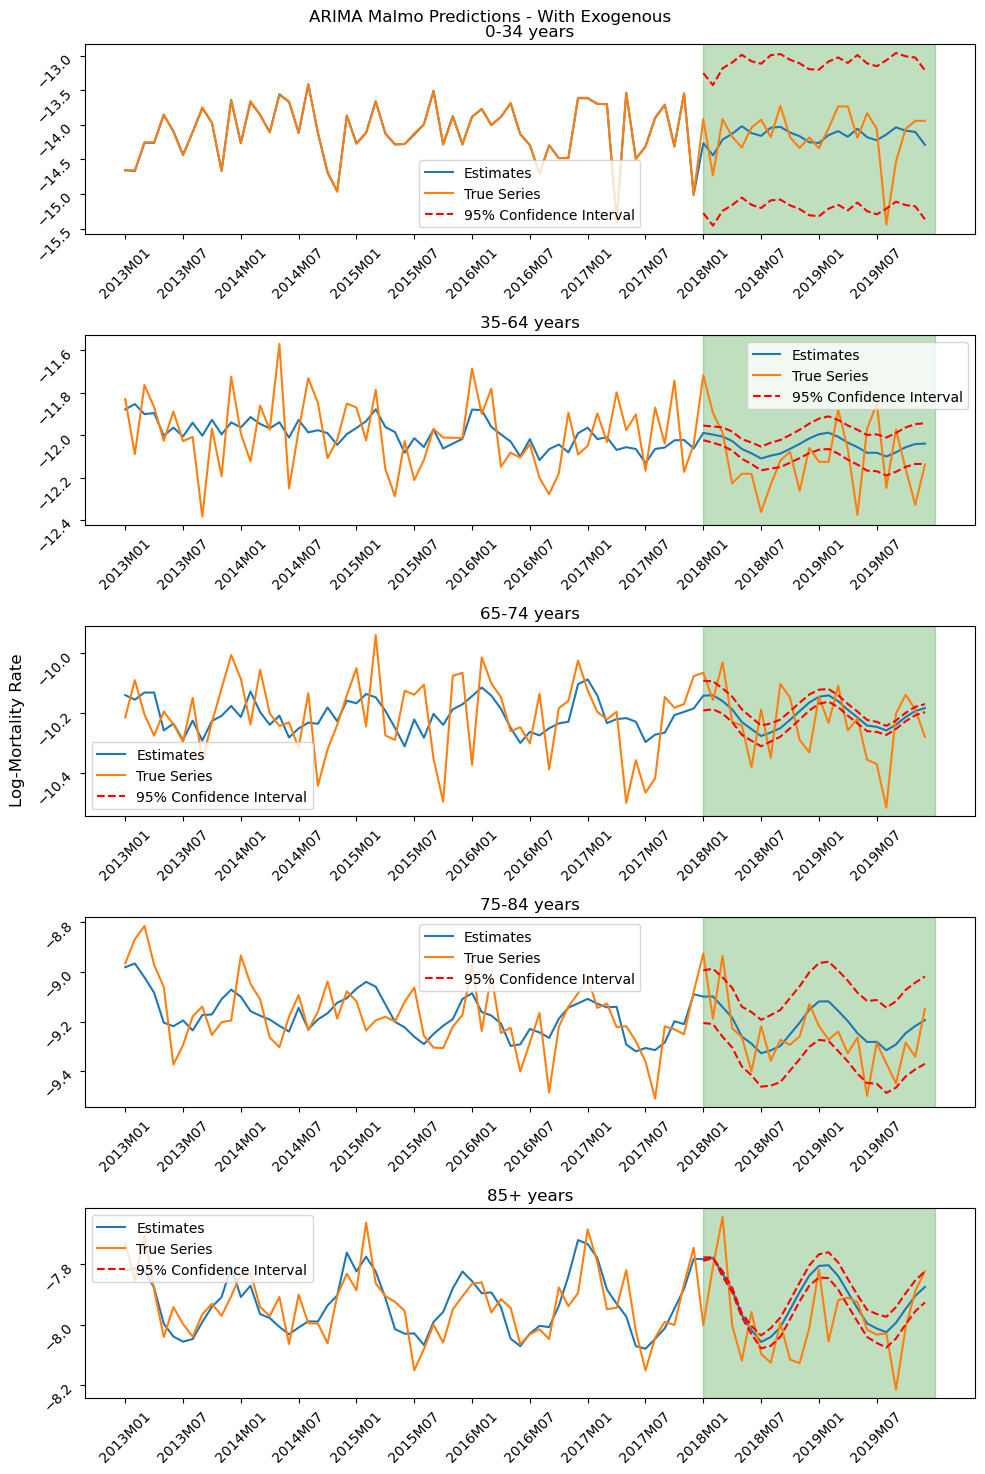

In [73]:
### With Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models,K_t_preds,k_t_preds,regional_predictions_sarwith,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_swe_logmort,malmo_logmort_full, common_terms = 4,regional_terms = 1,prediction_period = 24,train_period = 60,exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo,country_deaths = swe_death, country_pop = swe_pop,region_deaths = malmo_death,region_pop = malmo_pop,re_est = False,smooth=False)  


regional_predictions_sarwith = pd.DataFrame(regional_predictions_sarwith)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarwith.index = malmo_logmort_full.index
regional_predictions_sarwith.columns = malmo_logmort_full.columns
regional_predictions_upconf.index = malmo_logmort_full.index
regional_predictions_upconf.columns = malmo_logmort_full.columns
regional_predictions_lowconf.index = malmo_logmort_full.index
regional_predictions_lowconf.columns = malmo_logmort_full.columns

print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarwith.iloc[:,:60],malmo_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarwith.iloc[:,60:],malmo_logmort_full.iloc[:,60:])))

#print(str(k_t_models["model_0"].summary()))
#print(k_t_models["model_1"].summary())
error_SARIMAX_w= MAPE(regional_predictions_sarwith.iloc[:,60:],malmo_logmort_full.iloc[:,60:])

prediction_plots(regional_predictions_sarwith,regional_predictions_upconf,regional_predictions_lowconf,24,malmo_logmort_full,suptitle = "ARIMA Malmo Predictions - With Exogenous")



In [21]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print(str(K_t_models["model_1"].get_params()["order"]) + str(K_t_models["model_1"].get_params()["seasonal_order"]))

print(str(k_t_models["model_0"].get_params()["order"]) + str(k_t_models["model_0"].get_params()["seasonal_order"]))
print(str(k_t_models["model_1"].get_params()["order"]) + str(k_t_models["model_1"].get_params()["seasonal_order"]))



(1, 0, 0)(2, 0, 1, 12)
(1, 1, 1)(2, 0, 0, 12)
(0, 0, 0)(0, 0, 0, 12)
(0, 0, 0)(2, 0, 1, 12)


## VARMAX Models

test_errors[2.29412243 2.04361102 0.88869771 1.88843834 2.06173798]


<Figure size 640x480 with 0 Axes>

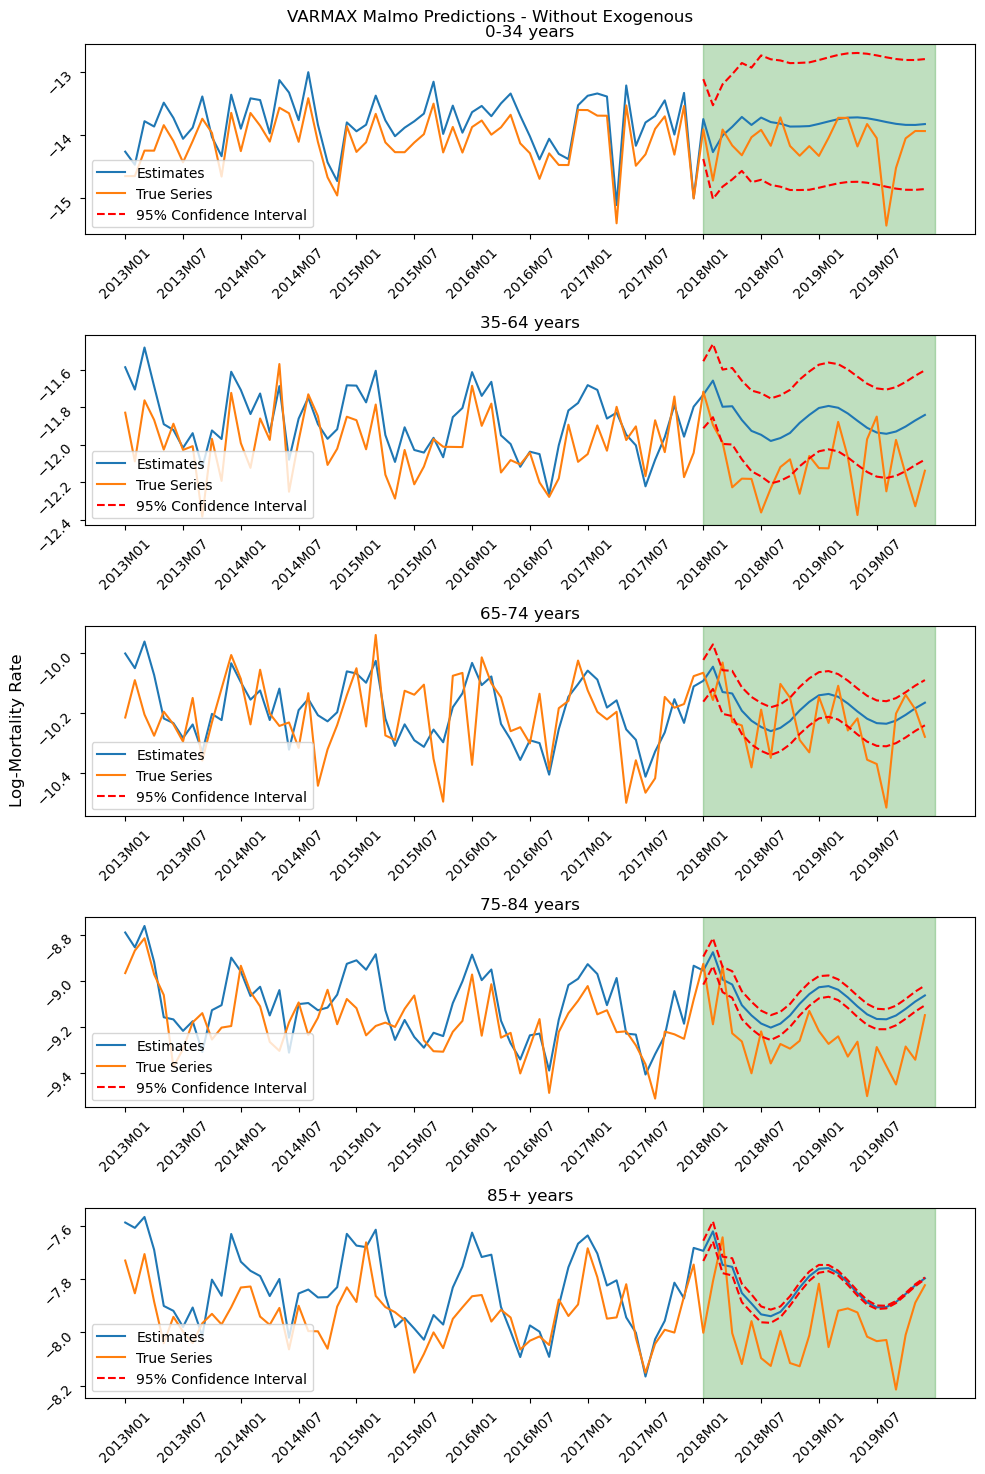

In [74]:
### Without Exogenous
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_varout,predictions_lowconf,predictions_upconf,model_VAR_wout,aic,error_VAR_wout,_,_ = VARMAX_model(all_swe_logmort,malmo_logmort_full, common_terms = 2,regional_terms = 2,prediction_period = 24,train_period = 60,AR= 3,MA = 6,country_deaths = swe_death,country_pop = swe_pop,region_deaths = malmo_death,region_pop = malmo_pop,re_est = False,smooth = False)

print("test_errors" + str(error_VAR_wout))
prediction_plots(predictions_varout,predictions_lowconf,predictions_upconf,24,malmo_logmort_full,suptitle = "VARMAX Malmo Predictions - Without Exogenous")



test_errors[3.23759405 2.0781241  0.99601596 1.80171184 1.98688503]


<Figure size 640x480 with 0 Axes>

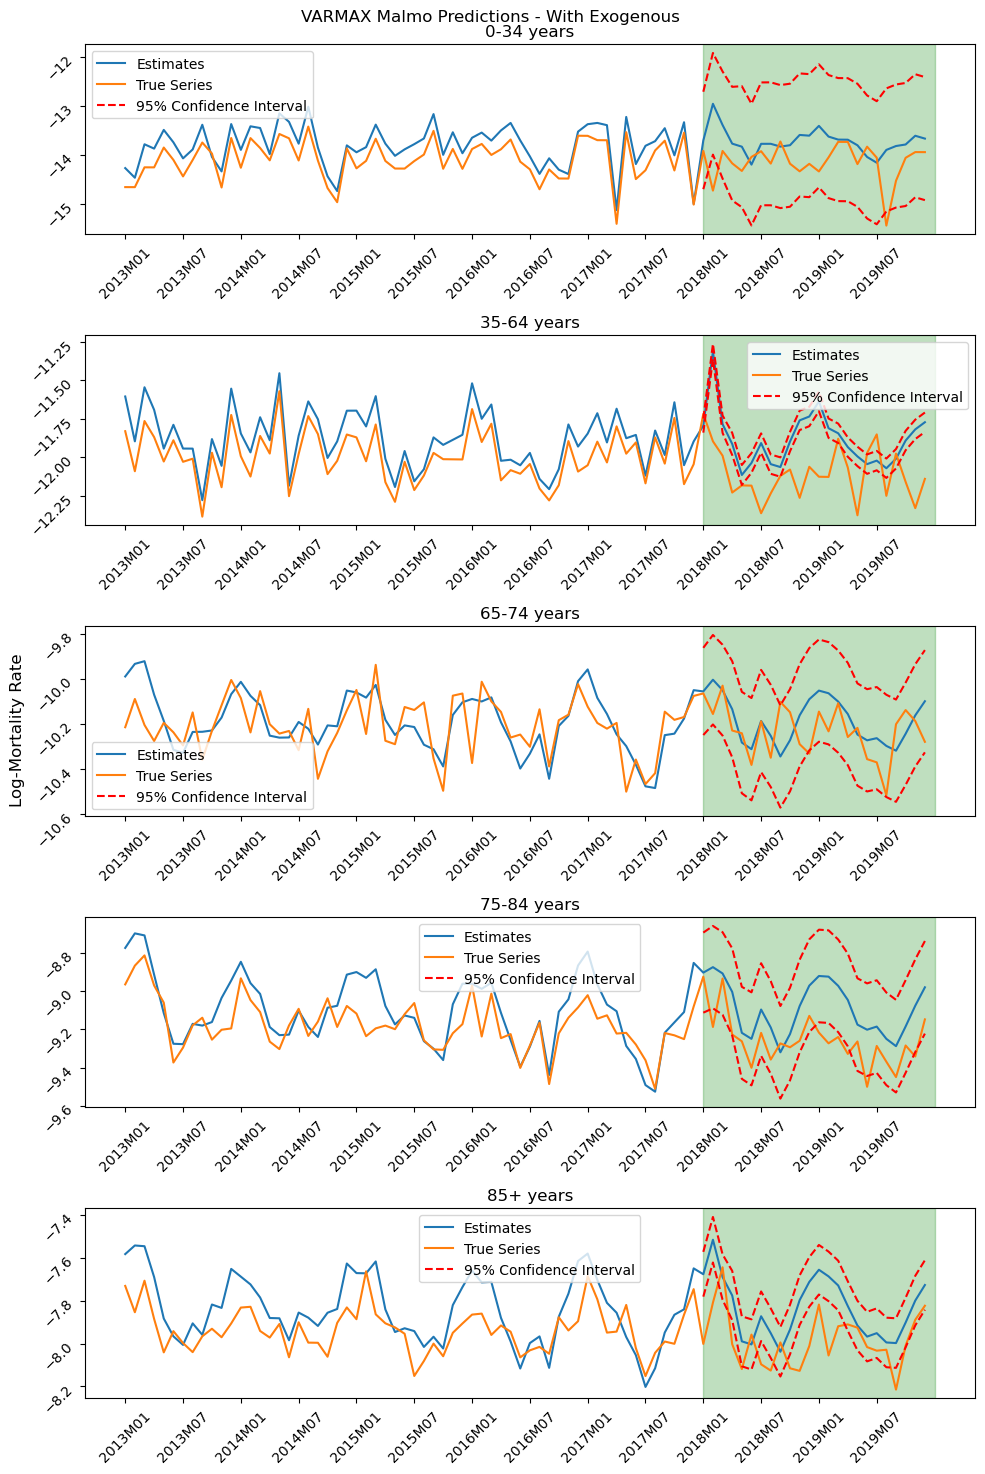

In [75]:
### With Exogenous
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_varwith,predictions_lowconf,predictions_upconf,model_VAR_with,aic,error_VAR_w,_,_ = VARMAX_model(all_swe_logmort,malmo_logmort_full, common_terms = 2,regional_terms = 3,prediction_period = 24,train_period = 60,AR= 2,MA = 4,exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo,country_deaths = swe_death,country_pop = swe_pop,region_deaths = malmo_death,region_pop = malmo_pop,re_est = False)

print("test_errors" + str(error_VAR_w))
prediction_plots(predictions_varwith,predictions_lowconf,predictions_upconf,24,malmo_logmort_full,suptitle = "VARMAX Malmo Predictions - With Exogenous")



In [14]:
model_VAR_with.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        [0, 1, 2, 3, 4]   No. Observations:                   60
Model:                   VARMAX(2,10)   Log Likelihood                 120.370
                          + intercept   AIC                            449.260
Date:                Thu, 27 Jun 2024   BIC                           1171.809
Time:                        11:47:09   HQIC                           731.889
Sample:                             0                                         
                                 - 60                                         
Covariance Type:                  opg                                         
==========================================================================================================
Ljung-Box (L1) (Q):     0.13, 0.61, 0.83, 0.31, 0.25   Jarque-Bera (JB):     1.03, 0.81, 1.76, 0.74, 16.31
Prob(Q):                0.72, 0.44, 0.36, 0.58, 0.61   Prob(JB):              0.60, 0.67, 0.41, 0.69, 0.00
Heteroskedasticity (H): 1.22, 1.82, 1.39, 0.96, 0.53   Skew:               -0.32, -0.10, 0.42, -0.16, 1.03
Prob(H) (two-sided):    0.67, 0.19, 0.47, 0.94, 0.17   Kurtosis:              3.04, 2.47, 2.91, 3.44, 4.52
                               Results for equation 0                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0192      0.007      2.815      0.005       0.006       0.033
L1.0                0.0181      0.009      2.031      0.042       0.001       0.036
L1.1                0.0992      0.019      5.178      0.000       0.062       0.137
L1.2               -0.2377      0.014    -17.408      0.000      -0.264      -0.211
L1.3               -0.2282      0.012    -19.572      0.000      -0.251      -0.205
L1.4                0.0074      0.019      0.382      0.703      -0.031       0.046
L2.0                0.0095      0.009      1.048      0.295      -0.008       0.027
L2.1                0.0150      0.020      0.740      0.459      -0.025       0.055
L2.2               -0.0532      0.016     -3.290      0.001      -0.085      -0.022
L2.3               -0.0520      0.012     -4.502      0.000      -0.075      -0.029
L2.4                0.0384      0.031      1.229      0.219      -0.023       0.100
L1.e(0)          5.252e-10      0.004   1.34e-07      1.000      -0.008       0.008
L1.e(1)          4.434e-10      0.015   2.95e-08      1.000      -0.029       0.029
L1.e(2)         -1.112e-09      0.011  -1.03e-07      1.000      -0.021       0.021
L1.e(3)          -2.17e-09      0.009  -2.32e-07      1.000      -0.018       0.018
L1.e(4)           3.98e-10      0.023    1.7e-08      1.000      -0.046       0.046
L2.e(0)         -1.731e-07      0.009     -2e-05      1.000      -0.017       0.017
L2.e(1)          -1.74e-07      0.012  -1.51e-05      1.000      -0.023       0.023
L2.e(2)         -1.732e-07      0.009  -1.91e-05      1.000      -0.018       0.018
L2.e(3)          -1.75e-07      0.010  -1.75e-05      1.000      -0.020       0.020
L2.e(4)         -1.701e-07      0.022  -7.65e-06      1.000      -0.044       0.044
L3.e(0)         -4.207e-07      0.007  -5.97e-05      1.000      -0.014       0.014
L3.e(1)         -4.221e-07      0.013   -3.3e-05      1.000      -0.025       0.025
L3.e(2)         -4.185e-07      0.012   -3.4e-05      1.000      -0.024       0.024
L3.e(3)         -4.192e-07      0.016  -2.59e-05      1.000      -0.032       0.032
L3.e(4)         -4.197e-07      0.021  -1.96e-05      1.000      -0.042       0.042
L4.e(0)         -6.256e-07      0.006     -0.000      1.000      -0.011       0.011
L4.e(1)         -6.264e

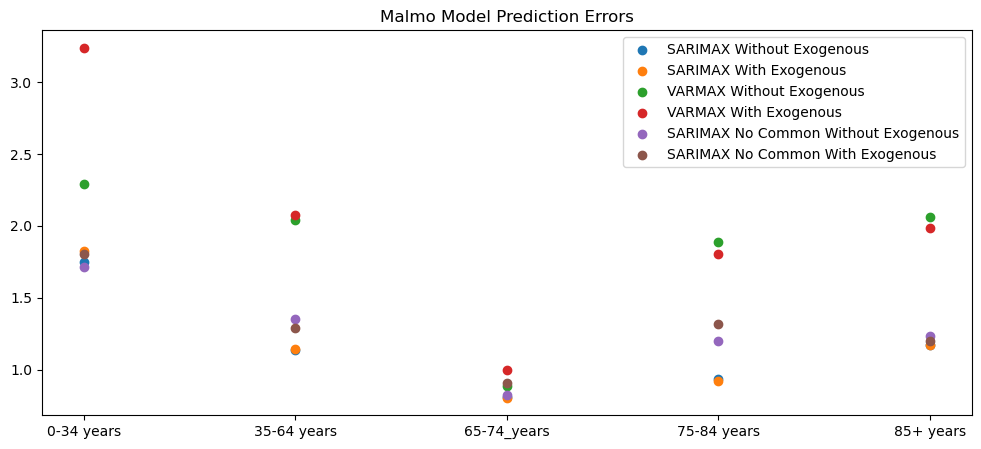

In [76]:
test_errors = np.vstack((error_SARIMAX_wout,error_SARIMAX_w,error_VAR_wout,error_VAR_w,error_NoCom_wout,error_NoCom_with))
malmo = test_errors

age_groups = ["0-34 years","35-64 years","65-74_years","75-84 years","85+ years"]
plt.figure(figsize = (12,5))
plt.scatter(age_groups,malmo[0,:],label = "SARIMAX Without Exogenous")
plt.scatter(age_groups,malmo[1,:],label = "SARIMAX With Exogenous")
plt.scatter(age_groups,malmo[2,:],label = "VARMAX Without Exogenous")
plt.scatter(age_groups,malmo[3,:],label = "VARMAX With Exogenous")
plt.scatter(age_groups,malmo[4,:],label = "SARIMAX No Common Without Exogenous")
plt.scatter(age_groups,malmo[5,:],label = "SARIMAX No Common With Exogenous")
plt.legend();
plt.title("Malmo Model Prediction Errors");

In [25]:
np.mean(malmo,axis = 1)

array([1.72872295, 1.74916724, 2.57777402, 2.88456225, 1.89074702,
       1.94705763])

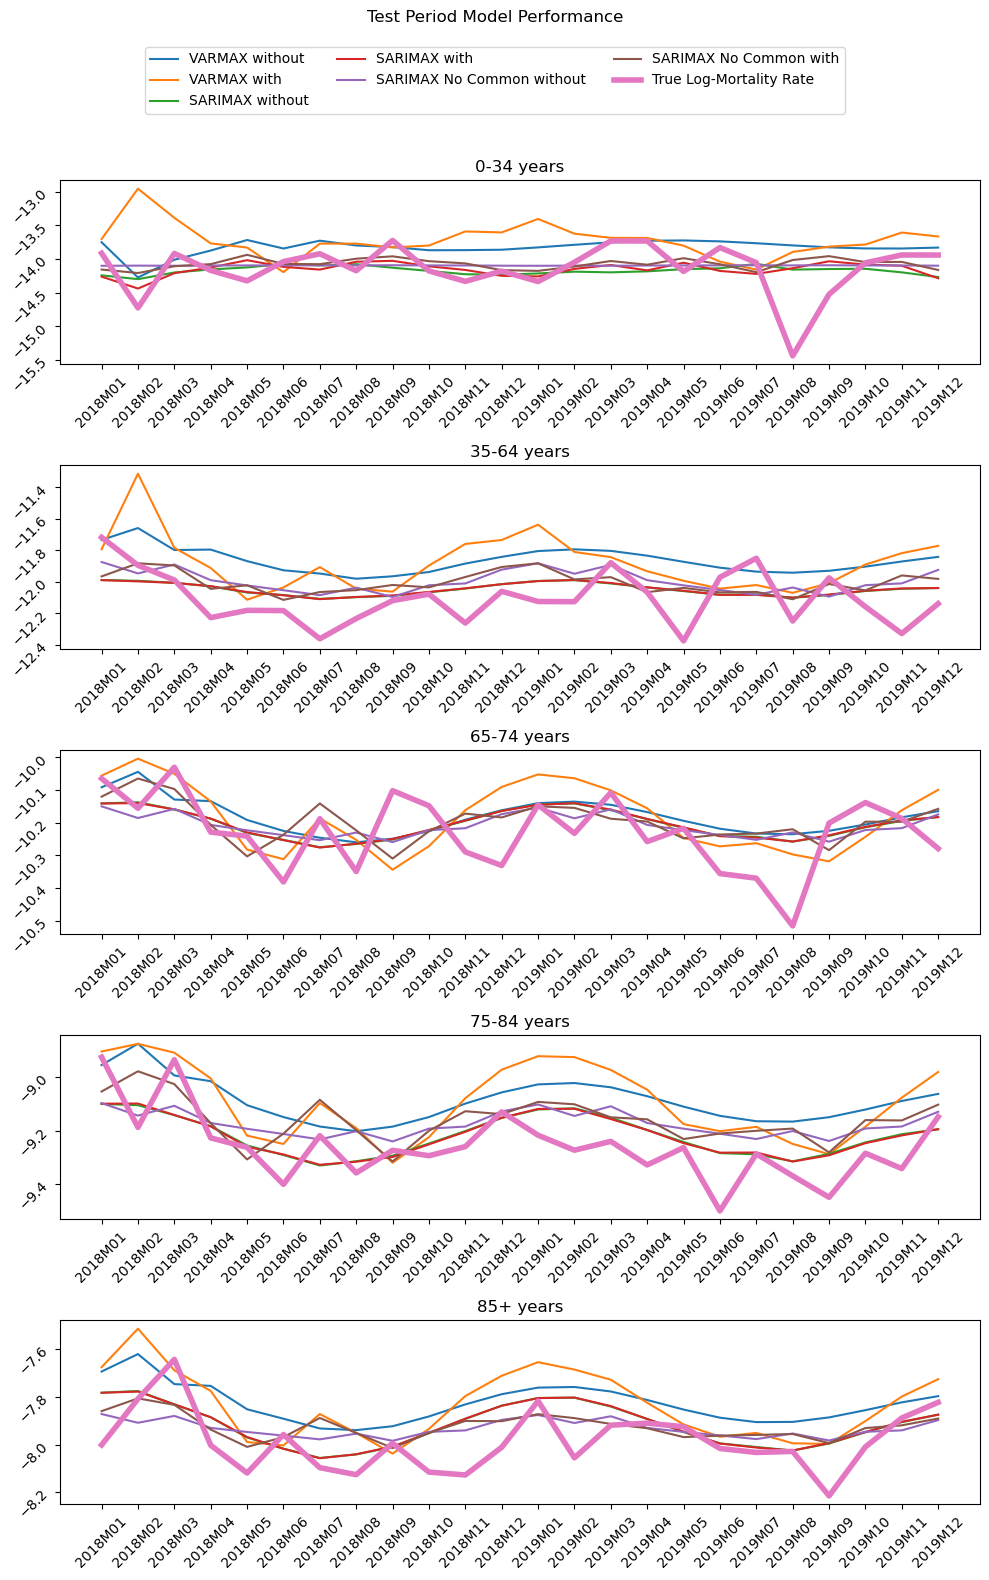

In [77]:
predictions_varwith = pd.DataFrame(predictions_varwith)
predictions_varwith.index = malmo_logmort_full.index
predictions_varwith.columns = malmo_logmort_full.columns

predictions_varout = pd.DataFrame(predictions_varout)
predictions_varout.index = malmo_logmort_full.index
predictions_varout.columns = malmo_logmort_full.columns


age_groups = ["0-34 years", "35-64 years", "65-74 years", "75-84 years", "85+ years"]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Store lines and labels to create a single legend
lines = []
labels = []

for row in range(5):
    age = age_groups[row]
    axes[row].set_title(age)
    
    line1, = axes[row].plot(predictions_varout.iloc[row, 60:], label="VARMAX without")
    line2, = axes[row].plot(predictions_varwith.iloc[row, 60:], label="VARMAX with")
    line3, = axes[row].plot(regional_predictions_sarout.iloc[row, 60:], label="SARIMAX without")
    line4, = axes[row].plot(regional_predictions_sarwith.iloc[row, 60:], label="SARIMAX with")
    line5, = axes[row].plot(regional_predictions_nocommout.iloc[row, 60:], label="SARIMAX No Common without")
    line6, = axes[row].plot(regional_predictions_nocommwith.iloc[row, 60:], label="SARIMAX No Common with")
    line7, = axes[row].plot(malmo_logmort_full.iloc[row, 60:], label="True Log-Mortality Rate", linewidth=4)
    
    axes[row].tick_params(rotation=45)
    
    # Collect lines and labels for the legend
    if row == 0:
        lines.extend([line1, line2, line3, line4, line5, line6, line7])
        labels.extend([line.get_label() for line in lines])

# Create a single legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
plt.suptitle("Test Period Model Performance", y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# COVID Period Modelling

p_value k_t0 before re-estimation: 0.49321590742954236 

Regional k_t0 is white noise with LB p_value 0.49321590742954236 

p_value k_t1 before re-estimation: 1.0785195373612859e-32 

Proportion of k_t values which are positive[0.48809524 0.52380952] 

Proportion of b_x values which are positive[0.  0.2] 

p_value k_t0 after re-estimation: 0.15465546098516092 

Regional k_t0 is white noise with LB p_value 0.15465546098516092 

p_value k_t1 after re-estimation: 1.0609674270979492e-13 

Model Error 6.981065464444326
Re_estimation error Each Age Group (MAPE): [0.02918443 0.65000585 0.8045372  0.81148933 0.88494362]

 Prediction Error Each Age Group (MAPE)[1.99777781 1.00208022 1.22546763 1.29364755 1.46209225]


<Figure size 640x480 with 0 Axes>

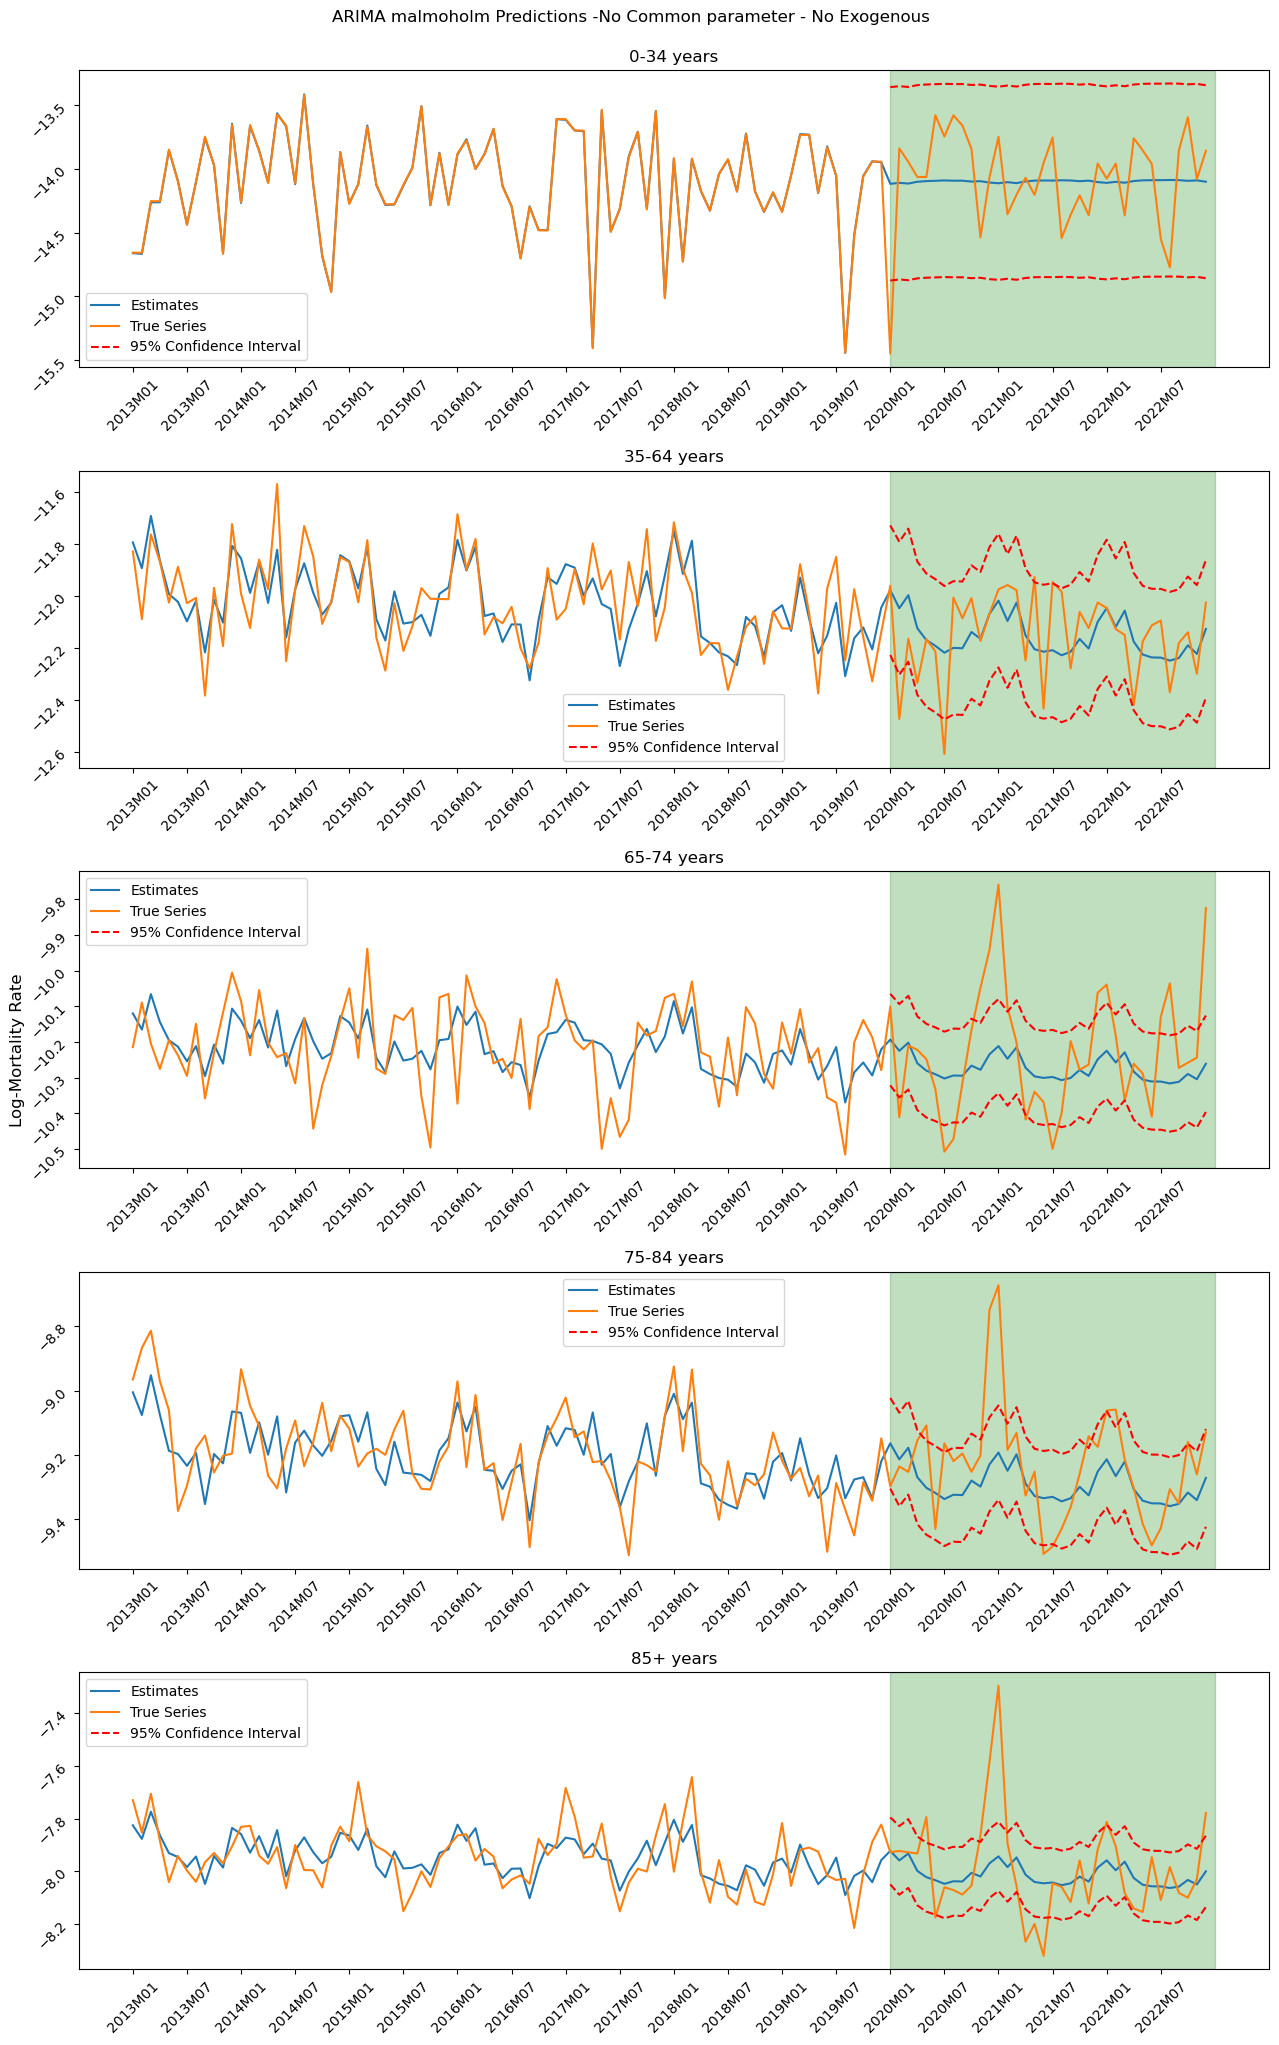

In [98]:
## Model No Common parameter - No Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommoutCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,D = model_no_common(malmo_logmort_incCOVID,regional_terms = 2,prediction_period = 36,train_period = 84,region_deaths = malmo_death_COVID,region_pop = malmo_pop_COVID,re_est = False,smooth = False)

#exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo
regional_predictions_nocommoutCOVID = pd.DataFrame(regional_predictions_nocommoutCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommoutCOVID.index = malmo_logmort_incCOVID.index
regional_predictions_nocommoutCOVID.columns = malmo_logmort_incCOVID.columns
regional_predictions_upconf.index = malmo_logmort_incCOVID.index
regional_predictions_upconf.columns = malmo_logmort_incCOVID.columns
regional_predictions_lowconf.index = malmo_logmort_incCOVID.index
regional_predictions_lowconf.columns = malmo_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommoutCOVID.iloc[:,:84],malmo_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommoutCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])))
#print(k_t_models["model_0"].summary())

#malmo_pop_inCOVID = undo_person_days(pd.DataFrame(malmo_pop_inCOVID,columns = malmo_logmort_incCOVID.columns[-36:]))


exp_term = np.multiply(np.exp(a_xi+b_xs@np.diag(D)[:2,:2]@k_t_preds[:,84:]),malmo_pop_inCOVID) ### Add scaling of singular values
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(malmo_death_inCOVID,axis = 1)

error_NoCom_woutCOVID = MAPE(regional_predictions_nocommoutCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_nocommoutCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,malmo_logmort_incCOVID,suptitle = "ARIMA malmoholm Predictions -No Common parameter - No Exogenous ")



In [99]:
malmo_NoCom_NoExog_deaths_20 = pd.DataFrame(exp_term).iloc[:,:6].sum(axis = 1) #only first half of 2020
malmo_NoCom_NoExog_deaths_20_21 = epi_year(pd.DataFrame(exp_term))["year_0"].sum(axis = 1)
malmo_NoCom_NoExog_deaths_21_22 = epi_year(pd.DataFrame(exp_term))["year_1"].sum(axis = 1)
malmo_NoCom_NoExog_deaths_22 = epi_year(pd.DataFrame(exp_term))["year_2"].sum(axis = 1)

p_value k_t0 before re-estimation: 0.49321590742954236 

Regional k_t0 is white noise with LB p_value 0.49321590742954236 

p_value k_t1 before re-estimation: 1.0785195373612859e-32 

p_value k_t2 before re-estimation: 0.0855592748392579 

Regional k_t2 is white noise with LB p_value 0.0855592748392579 

Proportion of k_t values which are positive[0.48809524 0.52380952 0.51190476] 

Proportion of b_x values which are positive[0.  0.2 0.8] 

p_value k_t0 after re-estimation: 0.15465546098516092 

Regional k_t0 is white noise with LB p_value 0.15465546098516092 

p_value k_t1 after re-estimation: 1.0609674270979492e-13 

p_value k_t2 after re-estimation: 0.15279661425857516 

Regional k_t2 is white noise with LB p_value 0.15279661425857516 

Model Error 6.831628290663288
Re_estimation error Each Age Group (MAPE): [0.02449759 0.04273913 0.67373582 0.53920747 0.76491969]

 Prediction Error Each Age Group (MAPE)[2.00258624 1.09055474 1.15590132 1.15677022 1.42581576]


<Figure size 640x480 with 0 Axes>

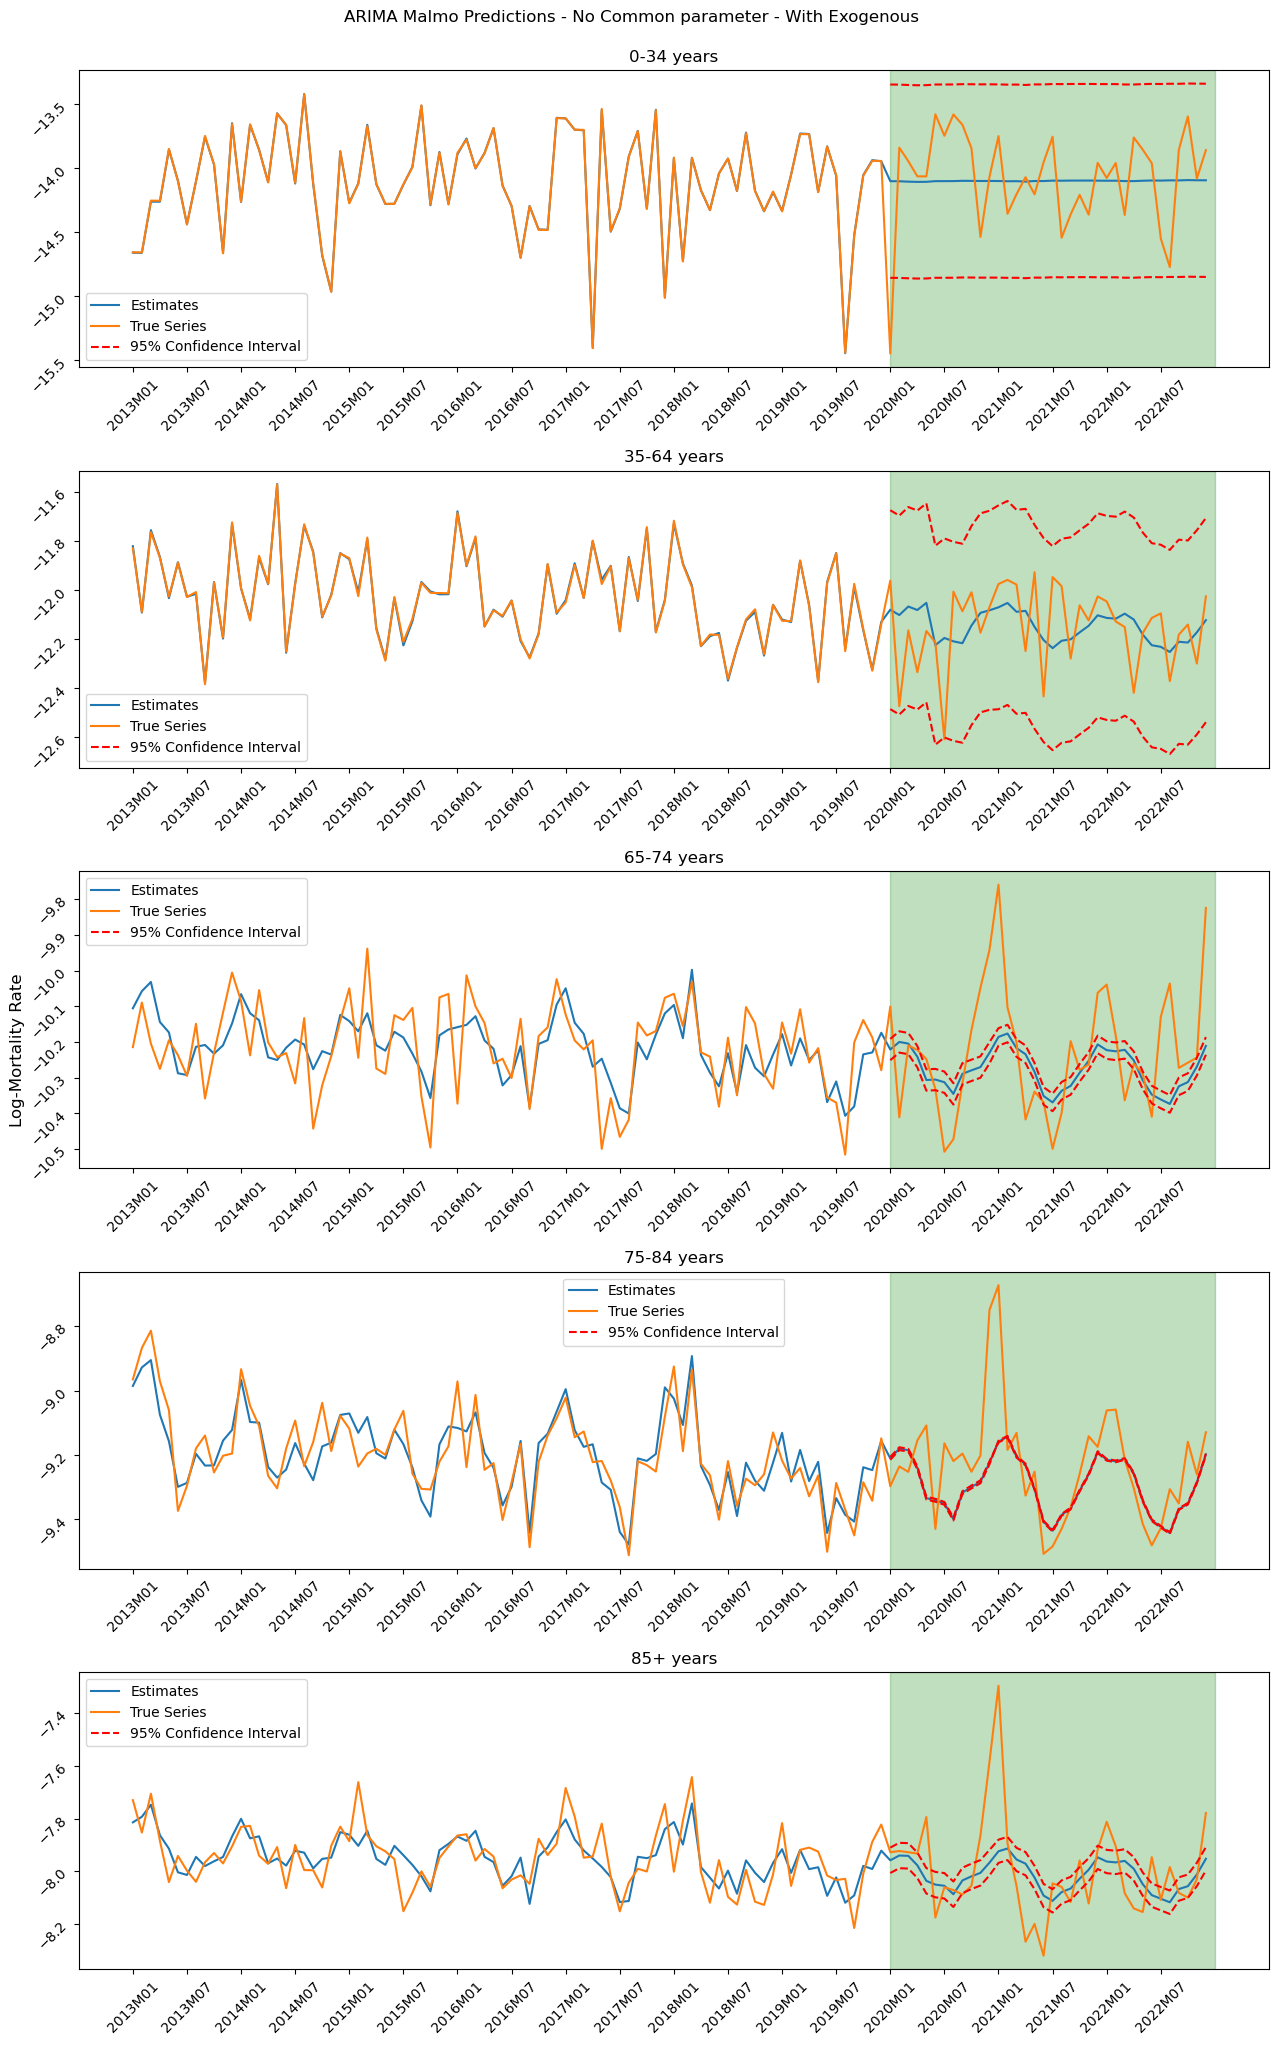

In [106]:
## Model No nocommon parameter - With Exogenous
exog_train_malmo_COVID_2 = exog_train_malmo_COVID.iloc[:,:2]
exog_test_malmo_COVID_2 = exog_test_malmo_COVID.iloc[:,:2]
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,D = model_no_common(malmo_logmort_incCOVID,regional_terms = 3,prediction_period = 36,train_period = 84,exogenous_train = exog_train_malmo_COVID_2,exogenous_test = exog_test_malmo_COVID_2,region_deaths = malmo_death_COVID,region_pop = malmo_pop_COVID,re_est = False,smooth = False)

#exogenous_train = exog_train_malmo,exogenous_test = exog_test_malmo
regional_predictions_nocommwithCOVID = pd.DataFrame(regional_predictions_nocommwithCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommwithCOVID.index = malmo_logmort_incCOVID.index
regional_predictions_nocommwithCOVID.columns = malmo_logmort_incCOVID.columns
regional_predictions_upconf.index = malmo_logmort_incCOVID.index
regional_predictions_upconf.columns = malmo_logmort_incCOVID.columns
regional_predictions_lowconf.index = malmo_logmort_incCOVID.index
regional_predictions_lowconf.columns = malmo_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommwithCOVID.iloc[:,:84],malmo_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommwithCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])))
#print(k_t_models["model_0"].summary())

#malmo_pop_inCOVID = undo_person_days(pd.DataFrame(malmo_pop_inCOVID,columns = malmo_logmort_incCOVID.columns[-36:]))


exp_term = np.multiply(np.exp(a_xi+ b_xs@np.diag(D)[:3,:3]@k_t_preds[:,84:]),malmo_pop_inCOVID) ### Add scaling of singular values
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(malmo_death_inCOVID,axis = 1)



error_NoCom_withCOVID = MAPE(regional_predictions_nocommwithCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_nocommwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,malmo_logmort_incCOVID,suptitle = "ARIMA Malmo Predictions - No Common parameter - With Exogenous ")



In [ ]:
malmo_NoCom_WithExog_deaths_20 = pd.DataFrame(exp_term).iloc[:,:6].sum(axis = 1) #only first half of 2020
malmo_NoCom_WithExog_deaths_20_21 = epi_year(pd.DataFrame(exp_term))["year_0"].sum(axis = 1)
malmo_NoCom_WithExog_deaths_21_22 = epi_year(pd.DataFrame(exp_term))["year_1"].sum(axis = 1)
malmo_NoCom_WithExog_deaths_22 = epi_year(pd.DataFrame(exp_term))["year_2"].sum(axis = 1)

p_value k_t0 before re-estimation: 2.1722801926571328e-17 

p_value k_t0 after re-estimation: 2.1722801926571328e-17 

Model Error 7.902328009245666
Re_estimation error Each Age Group (MAPE): [1.75044482 1.03189832 0.81479176 0.82166701 0.83074401]

 Prediction Error Each Age Group (MAPE)[2.27417957 1.00354726 1.24374878 1.48776974 1.47157315]

Predicted number of deaths for COVID period [ 250. 1702. 2598. 5013. 7082.]
Actual number of deaths for COVID period [ 304 1699 2739 5539 7364]
Actual deaths over predicted deaths [1.216      0.99823737 1.05427252 1.10492719 1.03981926]
Total Excess Mortality (Actual - Predicted): -1000.0
Excess Mortality Ratio (Actual/Predicted): 0.943326721450836


<Figure size 640x480 with 0 Axes>

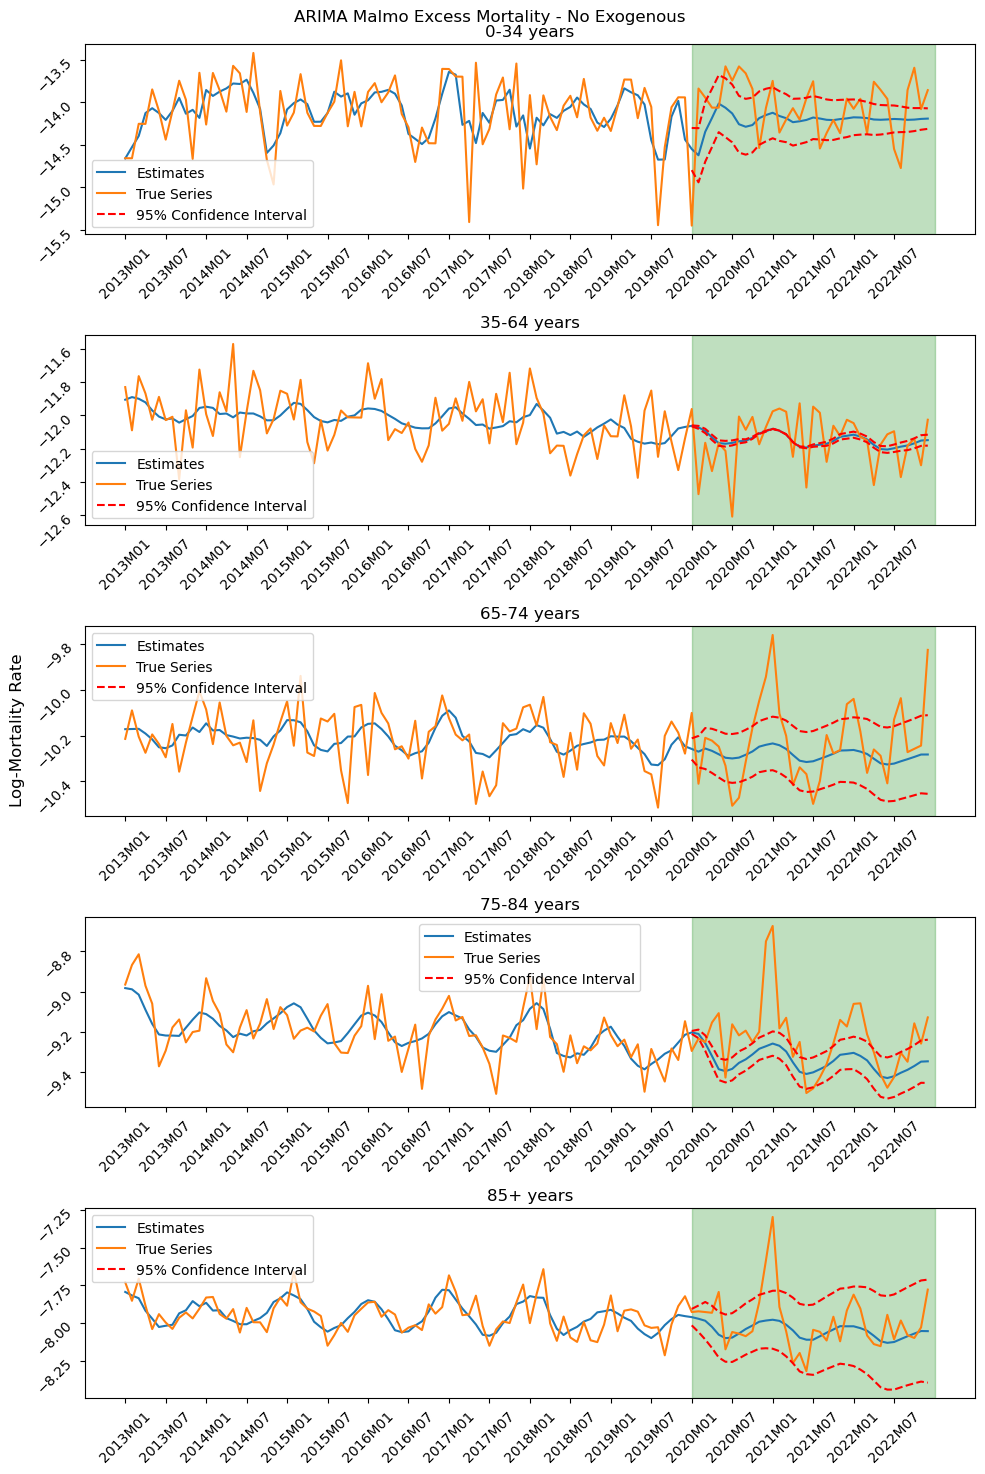

In [82]:
### Without Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models_sarout,K_t_preds,k_t_preds,regional_predictions_saroutCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_swe_logmort_incCOVID,malmo_logmort_incCOVID, common_terms = 2,regional_terms = 1,prediction_period = 36,train_period = 84,country_deaths = swe_death_COVID, country_pop = swe_pop_COVID,region_deaths = malmo_death_COVID,region_pop = malmo_pop_COVID,re_est = False,smooth = True)  


regional_predictions_saroutCOVID = pd.DataFrame(regional_predictions_saroutCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_saroutCOVID.index = malmo_logmort_incCOVID.index
regional_predictions_saroutCOVID.columns = malmo_logmort_incCOVID.columns
regional_predictions_upconf.index = malmo_logmort_incCOVID.index
regional_predictions_upconf.columns = malmo_logmort_incCOVID.columns
regional_predictions_lowconf.index = malmo_logmort_incCOVID.index
regional_predictions_lowconf.columns = malmo_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_saroutCOVID.iloc[:,:84],malmo_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_saroutCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])))

#malmo_pop_inCOVID = undo_person_days(pd.DataFrame(malmo_pop_inCOVID,columns = malmo_logmort_incCOVID.columns[-36:]))


exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds[:,84:] + b_xs@k_t_preds[:,84:]),malmo_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(malmo_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


regional_predictions_saroutCOVID
error_SARIMAX_woutCOVID = MAPE(regional_predictions_saroutCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_saroutCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,malmo_logmort_incCOVID,suptitle = "ARIMA Malmo Excess Mortality - No Exogenous")


In [83]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print(str(K_t_models["model_1"].get_params()["order"]) + str(K_t_models["model_1"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models_sarout["model_0"].get_params()["order"]) + str(k_t_models_sarout["model_0"].get_params()["seasonal_order"]))


(6, 1, 0)(1, 0, 2, 12)
(3, 1, 0)(2, 0, 0, 12)
-
(4, 0, 0)(0, 0, 0, 12)


p_value k_t0 before re-estimation: 1.0728961589080731e-19 

p_value k_t0 after re-estimation: 1.0728961589080731e-19 

Model Error 7.7768679776615866
Re_estimation error Each Age Group (MAPE): [1.75019842 1.0201228  0.81834189 0.82082233 0.82151719]

 Prediction Error Each Age Group (MAPE)[2.24179655 1.0643958  1.21192658 1.56500095 1.43190461]

Predicted number of deaths for COVID period [ 261. 1606. 2678. 4865. 7453.]
Actual number of deaths for COVID period [ 304 1699 2739 5539 7364]
Actual deaths over predicted deaths [1.16475096 1.05790785 1.02277819 1.1385406  0.9880585 ]
Total Excess Mortality (Actual - Predicted): -782.0
Excess Mortality Ratio (Actual/Predicted): 0.9556814961745537


<Figure size 640x480 with 0 Axes>

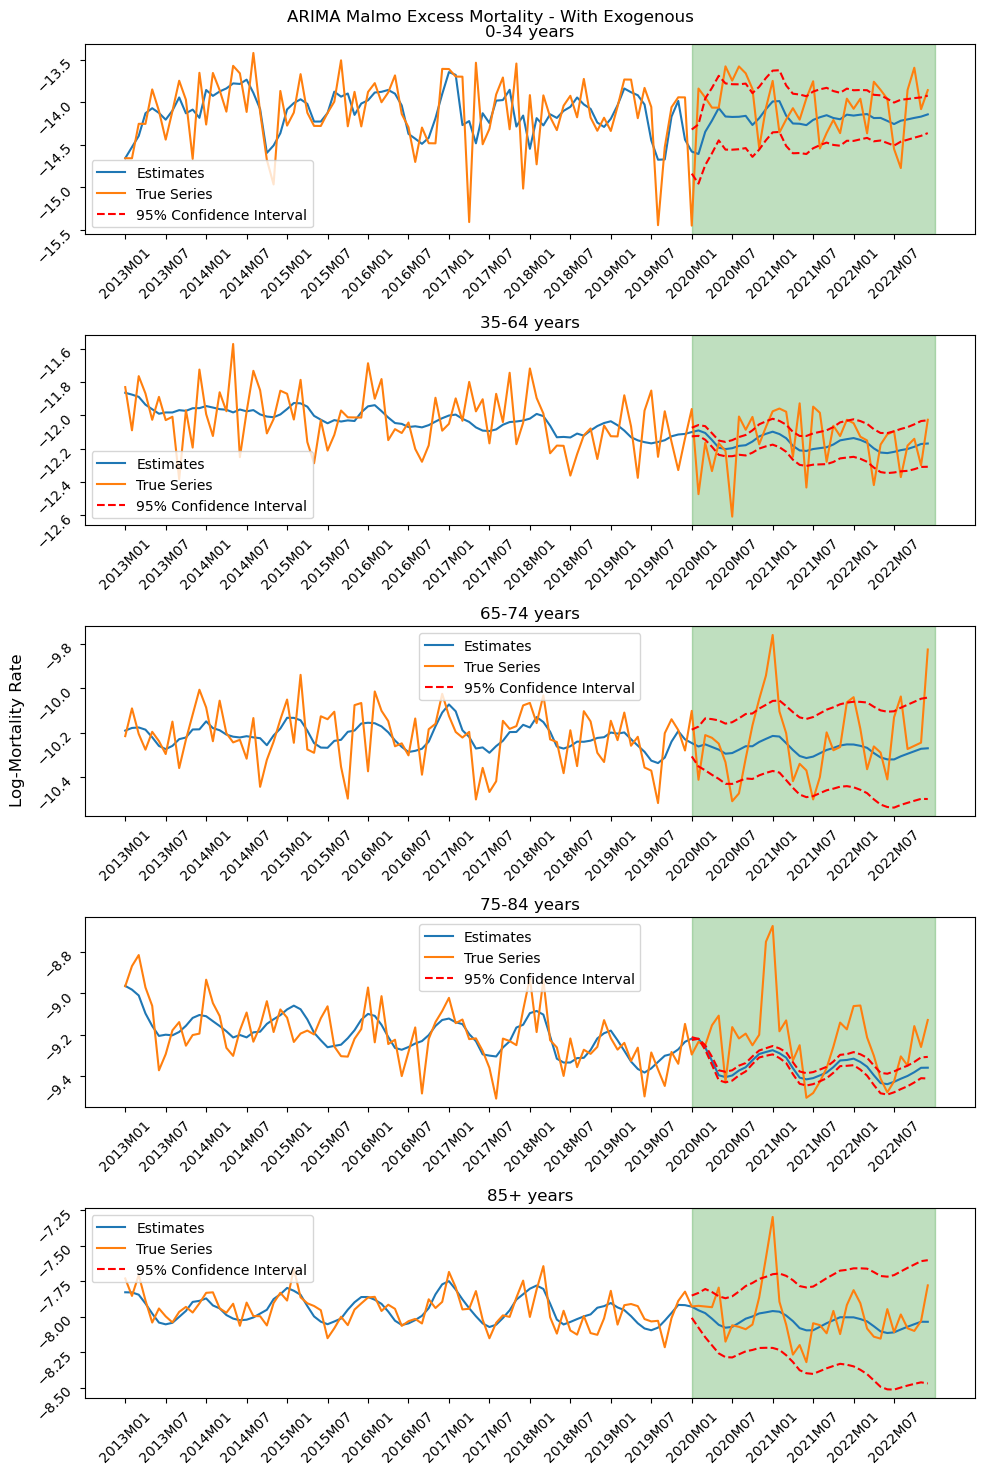

In [84]:
### With Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models_sarw,K_t_preds,k_t_preds,regional_predictions_sarwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_swe_logmort_incCOVID,malmo_logmort_incCOVID, common_terms = 3,regional_terms = 1,prediction_period = 36,train_period = 84,exogenous_train = exog_train_malmo_COVID,exogenous_test = exog_test_malmo_COVID,country_deaths = swe_death_COVID, country_pop = swe_pop_COVID,region_deaths = malmo_death_COVID,region_pop = malmo_pop_COVID,re_est = False,smooth = True)  


regional_predictions_sarwithCOVID = pd.DataFrame(regional_predictions_sarwithCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarwithCOVID.index = malmo_logmort_incCOVID.index
regional_predictions_sarwithCOVID.columns = malmo_logmort_incCOVID.columns
regional_predictions_upconf.index = malmo_logmort_incCOVID.index
regional_predictions_upconf.columns = malmo_logmort_incCOVID.columns
regional_predictions_lowconf.index = malmo_logmort_incCOVID.index
regional_predictions_lowconf.columns = malmo_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarwithCOVID.iloc[:,:84],malmo_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarwithCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])))

#malmo_pop_inCOVID = undo_person_days(pd.DataFrame(malmo_pop_inCOVID,columns = malmo_logmort_incCOVID.columns[-36:]))


exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds[:,84:] + b_xs@k_t_preds[:,84:]),malmo_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(malmo_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


error_SARIMAX_withCOVID = MAPE(regional_predictions_sarwithCOVID.iloc[:,84:],malmo_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_sarwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,malmo_logmort_incCOVID,suptitle = "ARIMA Malmo Excess Mortality - With Exogenous")



In [26]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print(str(K_t_models["model_1"].get_params()["order"]) + str(K_t_models["model_1"].get_params()["seasonal_order"]))
print(str(K_t_models["model_2"].get_params()["order"]) + str(K_t_models["model_2"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models_sarw["model_0"].get_params()["order"]) + str(k_t_models_sarw["model_0"].get_params()["seasonal_order"]))



(1, 1, 1)(2, 0, 1, 12)
(0, 0, 0)(0, 0, 0, 12)
(0, 0, 0)(0, 0, 0, 12)
-
(0, 0, 0)(0, 0, 0, 12)


test_errors[2.27013432 1.14797973 1.19485568 1.95609359 1.45478942]

Predicted number of deaths for COVID period [ 387. 1532. 2652. 4783. 8543.]
Actual number of deaths for COVID period [ 304 1699 2739 5539 7364]
Actual deaths over predicted deaths [0.78552972 1.10900783 1.03280543 1.1580598  0.86199227]
Total Excess Mortality (Actual - Predicted): 252.0
Excess Mortality Ratio (Actual/Predicted): 1.0142816661943894


<Figure size 640x480 with 0 Axes>

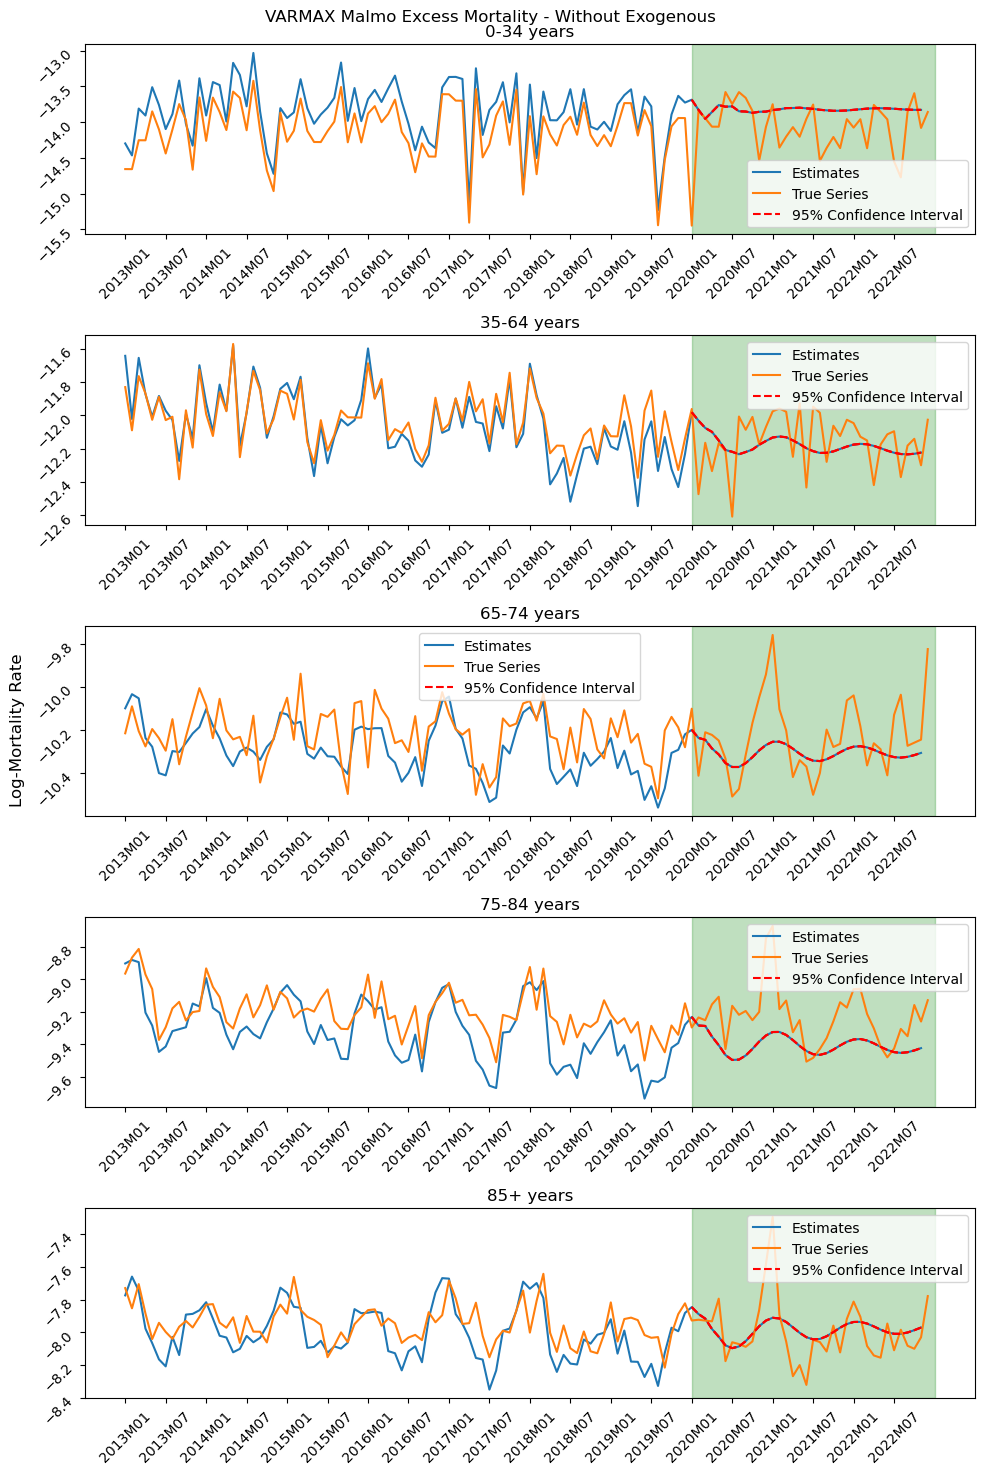

In [85]:
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_VAR_woutCOVID,predictions_lowconf,predictions_upconf,model_VAR_woutCOVID,aic,error_VAR_woutCOVID,_,_ = VARMAX_model(all_swe_logmort_incCOVID,malmo_logmort_incCOVID, common_terms = 3,regional_terms = 3,prediction_period = 36,train_period = 84,AR= 3,MA = 2, country_deaths = swe_death_COVID,country_pop = swe_pop_COVID,region_deaths = malmo_death_COVID,region_pop = malmo_pop_COVID,re_est = False)


print("test_errors" + str(error_VAR_woutCOVID))

K_t_preds = np.array(all_k_preds.iloc[84:,:3].fillna(method="ffill")).transpose() # change column number to match number of common terms
k_t_preds = np.array(all_k_preds.iloc[84:,3:]).transpose()

#malmo_pop_inCOVID = undo_person_days(pd.DataFrame(malmo_pop_inCOVID,columns = malmo_logmort_incCOVID.columns[-36:]))


exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds + b_xs@k_t_preds),malmo_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(malmo_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


prediction_plots(predictions_VAR_woutCOVID,predictions_VAR_woutCOVID,predictions_VAR_woutCOVID,36,malmo_logmort_incCOVID,suptitle = "VARMAX Malmo Excess Mortality - Without Exogenous")



In [146]:
all_k_preds

0         1         2         3
0    0.283574  0.145927  0.041899  0.547734
1    0.013756 -0.452096  0.190416  0.044508
2    0.209181  0.246366 -0.003971  0.229762
3    0.322183  0.062594  0.009033  0.189222
4    0.434352  0.150914  0.063838  0.315135
..        ...       ...       ...       ...
115  0.767760 -0.018451 -0.015381  0.421573
116  0.773424 -0.018666 -0.015209  0.420773
117  0.779013 -0.018930 -0.015091  0.420160
118  0.784584 -0.019084 -0.015019  0.419469
119       NaN -0.019320 -0.014955  0.418895

[120 rows x 4 columns]

test_errors[2.13315868 1.47813432 2.32668323 4.29130811 4.02359005]

Predicted number of deaths for COVID period [ 352. 1665. 2304. 4263. 5997.]
Actual number of deaths for COVID period [ 304 1699 2739 5539 7364]
Actual deaths over predicted deaths [0.86363636 1.02042042 1.18880208 1.29931973 1.22794731]


<Figure size 640x480 with 0 Axes>

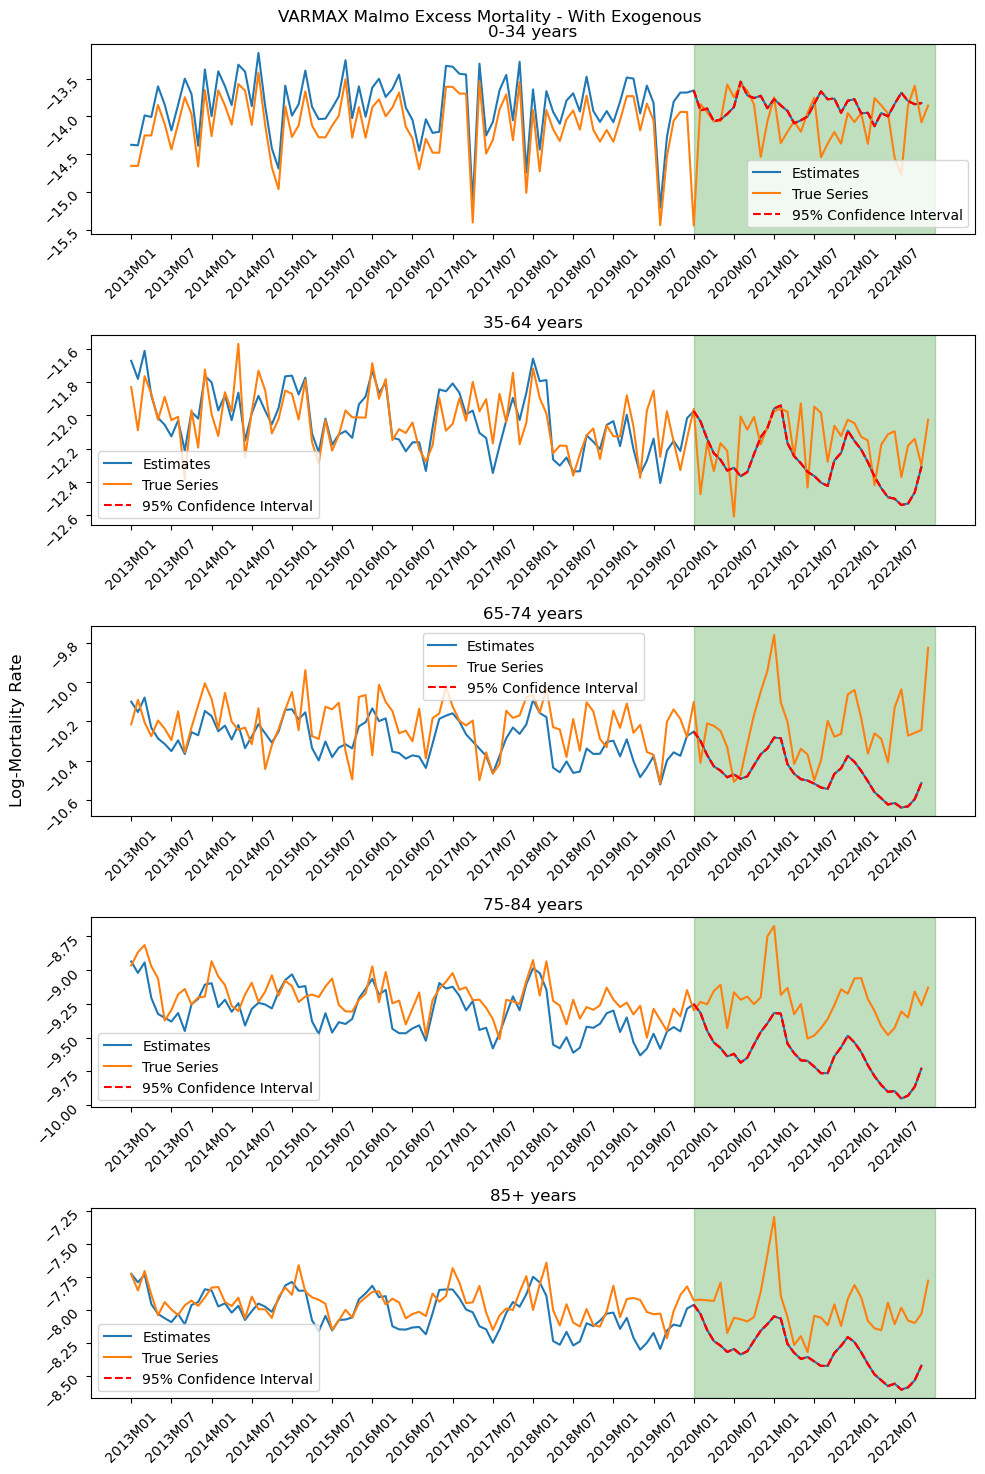

In [86]:
#exog_train_malmo_COVID = lag_exogenous(exog_train_malmo_COVID,numlags = 4)
#exog_test_malmo_COVID = lag_exogenous(exog_test_malmo_COVID,numlags = 4)
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_VAR_withCOVID,predictions_lowconf,predictions_upconf,model_VAR_withCOVID,aic,error_VAR_withCOVID,_,_ = VARMAX_model(all_swe_logmort_incCOVID,malmo_logmort_incCOVID, common_terms = 1,regional_terms = 2,prediction_period = 36,train_period = 84,AR= 4,MA = 4,exogenous_train = exog_train_malmo_COVID,exogenous_test = exog_test_malmo_COVID,country_deaths = swe_death_COVID, country_pop = swe_pop_COVID,region_deaths = malmo_death_COVID,region_pop = malmo_pop_COVID,re_est = False,smooth = False)


print("test_errors" + str(error_VAR_withCOVID))

K_t_preds = np.array(all_k_preds.iloc[84:,:1].fillna(method="ffill")).transpose()
k_t_preds = np.array(all_k_preds.iloc[84:,1:].fillna(method = "ffill")).transpose()

#malmo_pop_inCOVID = undo_person_days(pd.DataFrame(malmo_pop_inCOVID,columns = malmo_logmort_incCOVID.columns[-36:]))


exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds + b_xs@k_t_preds),malmo_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(malmo_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))

prediction_plots(predictions_VAR_withCOVID,predictions_VAR_withCOVID,predictions_VAR_withCOVID,36,malmo_logmort_incCOVID,suptitle = "VARMAX Malmo Excess Mortality - With Exogenous")


In [171]:
model_VAR_withCOVID.bic

439.3598364247971

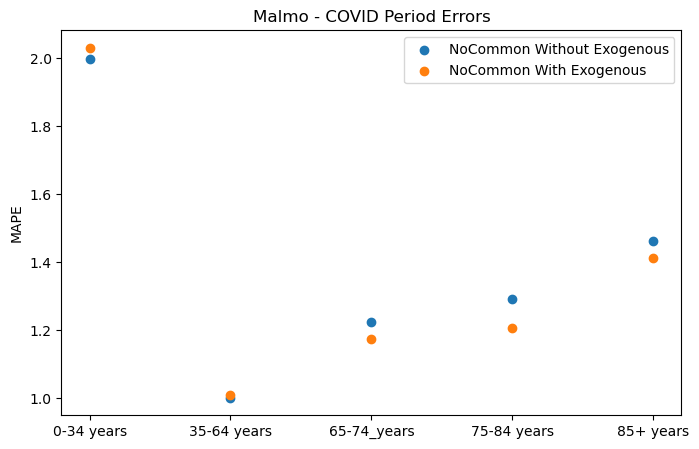

In [103]:
test_errors = np.vstack((error_SARIMAX_woutCOVID,error_SARIMAX_withCOVID,error_VAR_woutCOVID,error_VAR_withCOVID,error_NoCom_woutCOVID,error_NoCom_withCOVID))
malmoholm = test_errors

age_groups = ["0-34 years","35-64 years","65-74_years","75-84 years","85+ years"]
plt.figure(figsize = (8,5))
# plt.scatter(age_groups,malmoholm[0,:],label = "SARIMAX Without Exogenous")
# plt.scatter(age_groups,malmoholm[1,:],label = "SARIMAX With Exogenous")
# plt.scatter(age_groups,malmoholm[2,:],label = "VARMAX Without Exogenous")
# plt.scatter(age_groups,malmoholm[3,:],label = "VARMAX With Exogenous")
plt.scatter(age_groups,malmoholm[4,:],label = "NoCommon Without Exogenous")
plt.scatter(age_groups,malmoholm[5,:],label = "NoCommon With Exogenous")
plt.legend();
plt.ylabel("MAPE")
plt.title("Malmo - COVID Period Errors");

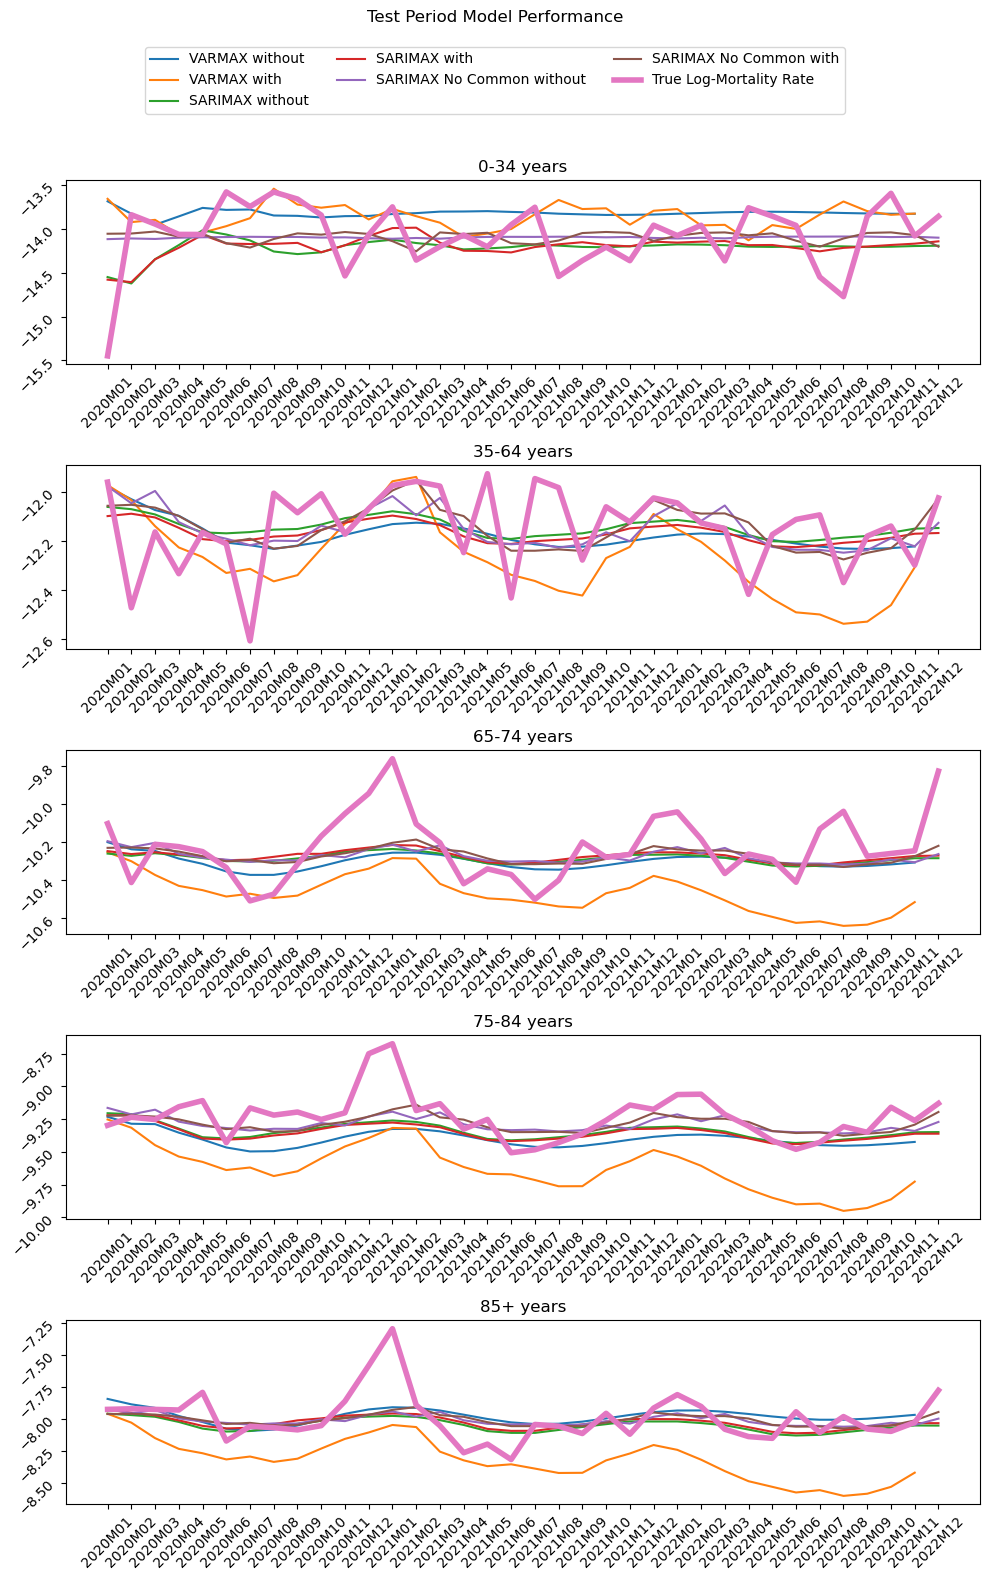

In [88]:
predictions_VAR_withCOVID = pd.DataFrame(predictions_VAR_withCOVID)
predictions_VAR_withCOVID.index = malmo_logmort_incCOVID.index
predictions_VAR_withCOVID.columns = malmo_logmort_incCOVID.columns

predictions_VAR_woutCOVID = pd.DataFrame(predictions_VAR_woutCOVID)
predictions_VAR_woutCOVID.index = malmo_logmort_incCOVID.index
predictions_VAR_woutCOVID.columns = malmo_logmort_incCOVID.columns


age_groups = ["0-34 years", "35-64 years", "65-74 years", "75-84 years", "85+ years"]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Store lines and labels to create a single legend
lines = []
labels = []

for row in range(5):
    age = age_groups[row]
    axes[row].set_title(age)
    
    line1, = axes[row].plot(predictions_VAR_woutCOVID.iloc[row, 84:], label="VARMAX without")
    line2, = axes[row].plot(predictions_VAR_withCOVID.iloc[row, 84:], label="VARMAX with")
    line3, = axes[row].plot(regional_predictions_saroutCOVID.iloc[row, 84:], label="SARIMAX without")
    line4, = axes[row].plot(regional_predictions_sarwithCOVID.iloc[row, 84:], label="SARIMAX with")
    line5, = axes[row].plot(regional_predictions_nocommoutCOVID.iloc[row, 84:], label="SARIMAX No Common without")
    line6, = axes[row].plot(regional_predictions_nocommwithCOVID.iloc[row, 84:], label="SARIMAX No Common with")
    line7, = axes[row].plot(malmo_logmort_incCOVID.iloc[row, 84:], label="True Log-Mortality Rate", linewidth=4)
    
    axes[row].tick_params(rotation=45)
    
    # Collect lines and labels for the legend
    if row == 0:
        lines.extend([line1, line2, line3, line4, line5, line6, line7])
        labels.extend([line.get_label() for line in lines])

# Create a single legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
plt.suptitle("Test Period Model Performance", y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Note: year 7 is only half an epiyear!  + First 6 months disregarded
Note: year 8 is only half an epiyear!  + First 6 months disregarded


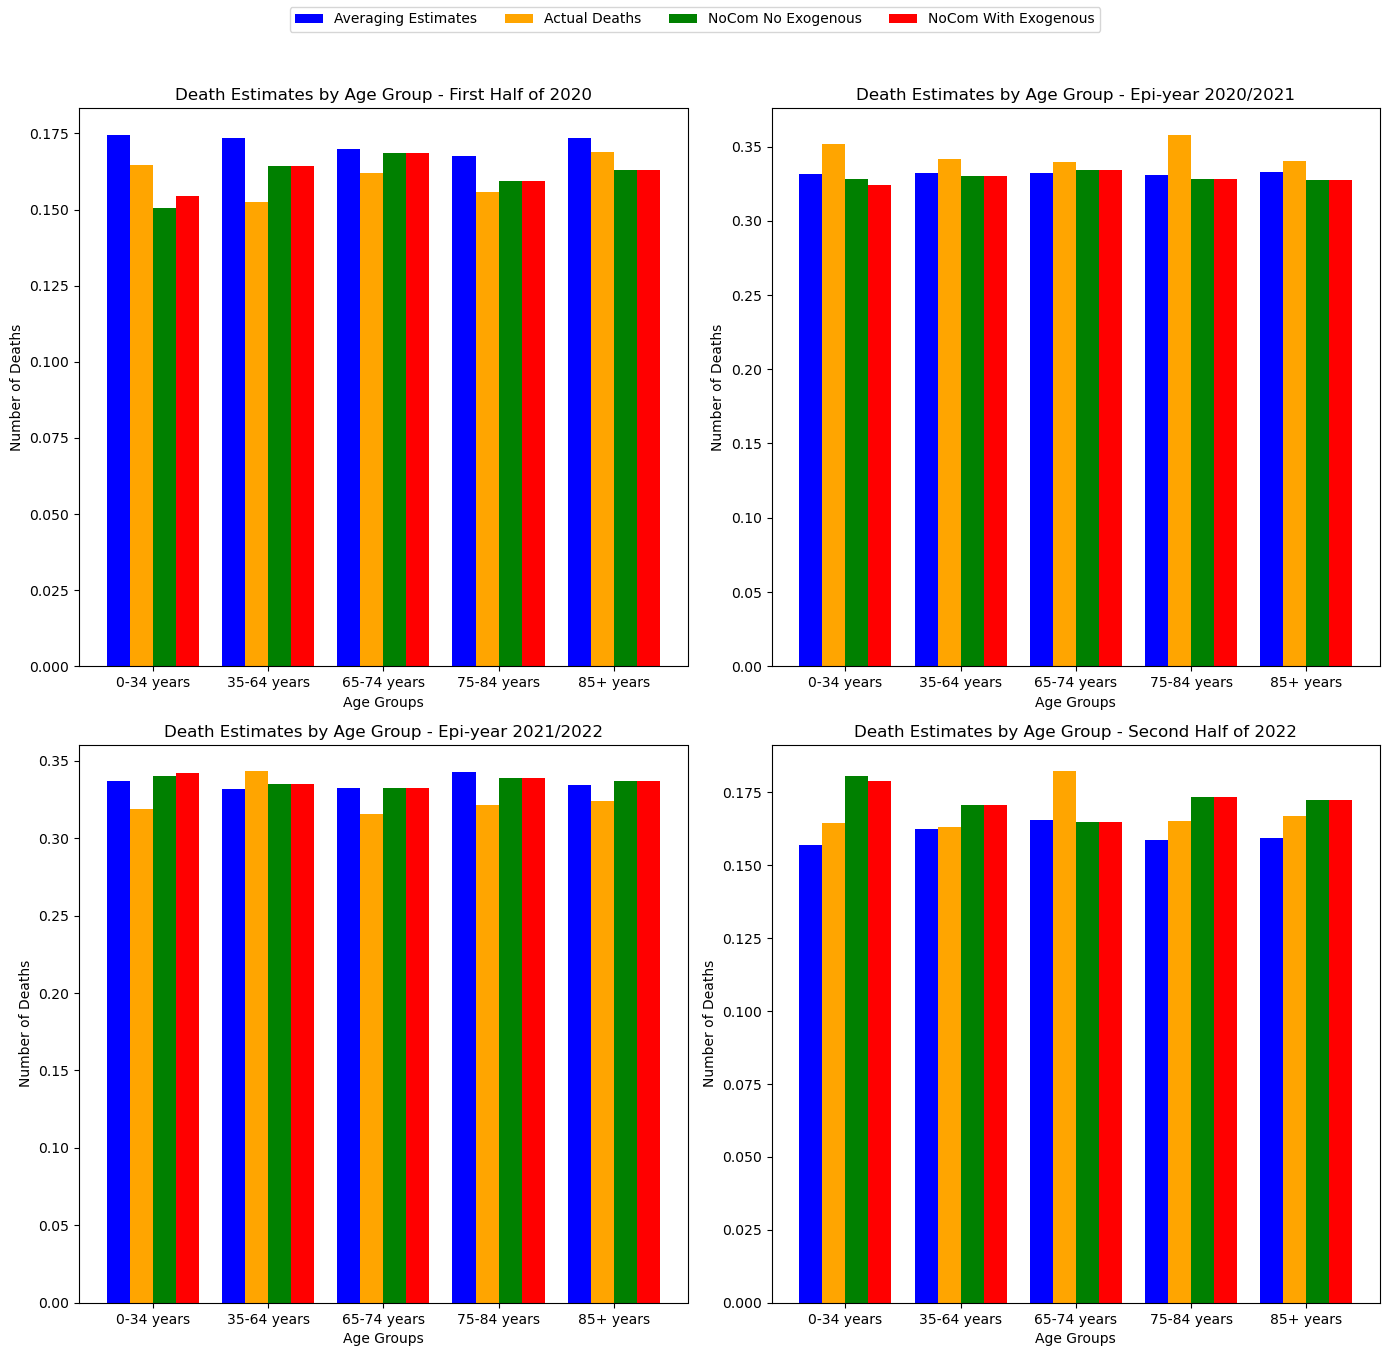

In [89]:
### Compile predictions for excess mortality for epidemic years
lin_ests_20 = np.round(est_half2_epiyear(malmo_death_COVID),0) #estimate for first 6 moths of 2020 ie. second half epi-year 19/20

#Use 2019/20 epi-year in estimate for epi-year 2020/21?  
lin_ests_20_21 = np.reshape(epi_year_lin_ests(pd.DataFrame(malmo_death_full.iloc[:,:96])),(5,))
lin_ests_21_22 = np.reshape(epi_year_lin_ests(pd.DataFrame(malmo_death_full.iloc[:,:108])),(5,))

#estimate for last 6 months of 2022 ie. first half epi-year 19/20
lin_ests_22 = np.round(est_half1_epiyear(malmo_death_COVID),0) #estimate for first 6 moths of 2020 ie. second half epi-year 19/20

# only first half of 2020, second half of epi-year 19/20
malmo_actual_deaths_20 = malmo_death_full.iloc[:,84:90].sum(axis = 1) 
malmo_actual_deaths_20_21 = epi_year(malmo_death_full.iloc[:,84:])["year_0"].sum(axis = 1)
malmo_actual_deaths_21_22 = epi_year(malmo_death_full.iloc[:,84:])["year_1"].sum(axis = 1)
malmo_actual_deaths_22 = epi_year(malmo_death_full.iloc[:,84:])["year_2"].sum(axis = 1) #only second half of 2022 


age_groups = malmo_logmort_full.index
r = np.arange(len(age_groups))
width = 0.2  # Adjusting width to fit four bars

fig, axes = plt.subplots(2, 2, figsize=(14, 14))  # Creating a 2x2 grid of subplots

# Labels for the legends
labels = ["Averaging Estimates", "Actual Deaths", "NoCom No Exogenous", "NoCom With Exogenous"]

# Defining data sets for each subplot
data_sets = [
    (lin_ests_20, malmo_actual_deaths_20, malmo_NoCom_NoExog_deaths_20, malmo_NoCom_WithExog_deaths_20),
    (lin_ests_20_21, malmo_actual_deaths_20_21, malmo_NoCom_NoExog_deaths_20_21, malmo_NoCom_WithExog_deaths_20_21),
    (lin_ests_21_22, malmo_actual_deaths_21_22, malmo_NoCom_NoExog_deaths_21_22, malmo_NoCom_WithExog_deaths_21_22),
    (lin_ests_22, malmo_actual_deaths_22, malmo_NoCom_NoExog_deaths_22, malmo_NoCom_WithExog_deaths_22)
]
data_sets = data_sets/np.sum(data_sets,axis = 0)
titles = [
    'Death Estimates by Age Group - First Half of 2020',
    'Death Estimates by Age Group - Epi-year 2020/2021',
    'Death Estimates by Age Group - Epi-year 2021/2022',
    'Death Estimates by Age Group - Second Half of 2022'
]

for ax, data, title in zip(axes.flatten(), data_sets, titles):
    lin_est, actual_death, NoCom_noexog, NoCom_withexog = data
    ax.bar(r - 1.5*width, lin_est, width=width, align="center", color="blue", label=labels[0])
    ax.bar(r - 0.5*width, actual_death, width=width, align="center", color="orange", label=labels[1])
    ax.bar(r + 0.5*width, NoCom_noexog, width=width, align="center", color="green", label=labels[2])
    ax.bar(r + 1.5*width, NoCom_withexog, width=width, align="center", color="red", label=labels[3])
    ax.set_xticks(r)
    ax.set_xticklabels(age_groups)
    ax.set_xlabel('Age Groups')
    ax.set_ylabel('Number of Deaths')
    ax.set_title(title)

# Adding a single legend for the whole figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend
plt.show()






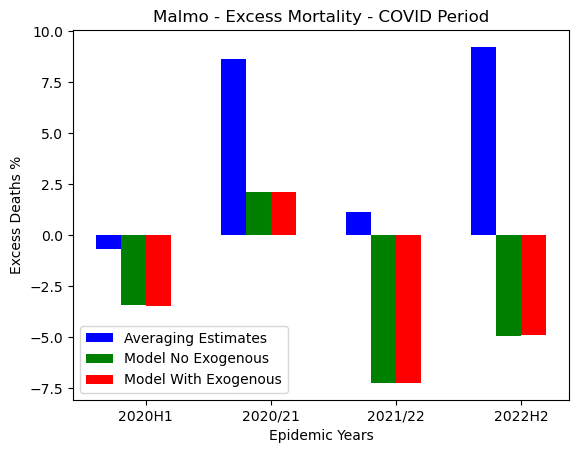

In [105]:


malmo_actual_deaths_total_20 = np.sum(malmo_actual_deaths_20)
lin_ests_excess_20 = (malmo_actual_deaths_total_20 - np.sum(lin_ests_20))/malmo_actual_deaths_total_20 *100
malmo_NoCom_NoExog_excess_total_20 = (malmo_actual_deaths_total_20 - np.sum(malmo_NoCom_NoExog_deaths_20))/malmo_actual_deaths_total_20 *100
malmo_NoCom_WithExog_excess_total_20 = (malmo_actual_deaths_total_20 - np.sum(malmo_NoCom_WithExog_deaths_20))/malmo_actual_deaths_total_20 *100

malmo_actual_deaths_total_20_21 = np.sum(malmo_actual_deaths_20_21)
lin_ests_excess_20_21 = (malmo_actual_deaths_total_20_21 - np.sum(lin_ests_20_21))/malmo_actual_deaths_total_20_21 *100
malmo_NoCom_NoExog_excess_total_20_21 = (malmo_actual_deaths_total_20_21 - np.sum(malmo_NoCom_NoExog_deaths_20_21))/malmo_actual_deaths_total_20_21 *100
malmo_NoCom_WithExog_excess_total_20_21 = (malmo_actual_deaths_total_20_21 - np.sum(malmo_NoCom_WithExog_deaths_20_21))/malmo_actual_deaths_total_20_21 *100

malmo_actual_deaths_total_21_22 = np.sum(malmo_actual_deaths_21_22)
lin_ests_excess_21_22 = (malmo_actual_deaths_total_21_22 - np.sum(lin_ests_21_22))/malmo_actual_deaths_total_21_22 *100
malmo_NoCom_NoExog_excess_total_21_22 = (malmo_actual_deaths_total_21_22 - np.sum(malmo_NoCom_NoExog_deaths_21_22))/malmo_actual_deaths_total_21_22 *100
malmo_NoCom_WithExog_excess_total_21_22 = (malmo_actual_deaths_total_21_22 - np.sum(malmo_NoCom_WithExog_deaths_21_22))/malmo_actual_deaths_total_21_22 *100

malmo_actual_deaths_total_22 = np.sum(malmo_actual_deaths_22)
lin_ests_excess_22 = (malmo_actual_deaths_total_22 - np.sum(lin_ests_22))/malmo_actual_deaths_total_22 *100
malmo_NoCom_NoExog_excess_total_22 = (malmo_actual_deaths_total_22 - np.sum(malmo_NoCom_NoExog_deaths_22))/malmo_actual_deaths_total_22 *100
malmo_NoCom_WithExog_excess_total_22 = (malmo_actual_deaths_total_22 - np.sum(malmo_NoCom_WithExog_deaths_22))/malmo_actual_deaths_total_22 *100


# Assuming malmo_logmort_full, lin_ests_20, malmo_actual_deaths_20, malmo_NoCom_NoExog_deaths_20, and malmo_NoCom_WithExog_deaths_20 are defined
# malmo_logmort_full.index should be a list or an array of age groups

years = ["2020H1", "2020/21","2021/22", "2022H2"]
r = np.arange(len(years))
width = 0.2  # Adjusting width to fit four bars

# Labels for the legends
labels = ["Averaging Estimates", "Model No Exogenous", "Model With Exogenous","_nolegend_"]

plt.bar(r[0] - 1.5*width, lin_ests_excess_20, width=0.2, align="center", color="blue", label=labels[0])
plt.bar(r[0] - 0.5*width, malmo_NoCom_NoExog_excess_total_20, width=0.2, align="center", color="green", label=labels[1])
plt.bar(r[0] + 0.5*width, malmo_NoCom_WithExog_excess_total_20, width=0.2, align="center", color="red", label=labels[2])
#plt.bar(r[0] + 1.5*width, malmo_actual_deaths_total_20, width=0.2, align="center", color="orange", label=labels[0])

plt.bar(r[1] - 1.5*width, lin_ests_excess_20_21, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[1] - 0.5*width, malmo_NoCom_NoExog_excess_total_20_21, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[1] + 0.5*width, malmo_NoCom_WithExog_excess_total_20_21, width=0.2, align="center", color="red", label=labels[3])
#plt.bar(r[1] + 1.5*width, malmo_actual_deaths_total_20_21, width=0.2, align="center", color="orange", label=labels[0])

plt.bar(r[2] - 1.5*width, lin_ests_excess_21_22, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[2] - 0.5*width, malmo_NoCom_NoExog_excess_total_21_22, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[2] + 0.5*width, malmo_NoCom_WithExog_excess_total_21_22, width=0.2, align="center", color="red", label=labels[3])

plt.bar(r[3] - 1.5*width, lin_ests_excess_22, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[3] - 0.5*width, malmo_NoCom_NoExog_excess_total_22, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[3] + 0.5*width, malmo_NoCom_WithExog_excess_total_22, width=0.2, align="center", color="red", label=labels[3])

plt.xticks(r, years)
plt.legend()
plt.xlabel('Epidemic Years')
plt.ylabel('Excess Deaths %')
plt.title('Malmo - Excess Mortality - COVID Period');
# plt.show()



In [ ]:
k_t_models_sarw["model_1"].summary()